In [1]:
# === Genome3D v1s — Starspread (real genes, no dust) =========================
# Spread each gene off its chromosome backbone using a local T/N/B frame.
# Saves:
#   tables: genome3d__atlas__nodes_v1s.parquet   ["genome3d","atlas","v1s"]
#   figure: genome3d__atlas__figure_v1s.png      ["genome3d","atlas","v1s"]
#   html:   genome3d__atlas__interactive_v1s.html["genome3d","atlas","v1s","interactive"]
# Inputs: v1h nodes/edges (from manifest). No fake points—only your genes.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P

# ---- Tuning knobs ------------------------------------------------------------
R_PERP   = 0.35   # mean radial offset (in scene units) from backbone into N/B plane
R_JITTER = 0.20   # additional random jitter fraction
SEED     = 1337   # RNG seed for reproducibility
THICK_BACKBONES = 2
FAINT_ALPHA     = 0.25

# ---- Load v1h nodes + edges --------------------------------------------------
def hits(kind,*tags): return cl.manifest.find_artifacts(kind=kind, tags_all=list(tags))
nodes_pq = [h["path"] for h in hits("table","genome3d","atlas","v1h") if "nodes" in Path(h["path"]).name][-1]
edges_pq = [h["path"] for h in hits("table","genome3d","atlas","v1h") if "edges" in Path(h["path"]).name][-1]

nodes_v1h = pd.read_parquet(nodes_pq)
edges_v1h = pd.read_parquet(edges_pq)

genes = nodes_v1h[nodes_v1h["kind"].astype(str).str.lower()=="gene"].copy()
anchors = nodes_v1h[nodes_v1h["kind"].astype(str).str.lower()=="anchor"].copy()

# Rebuild per-chromosome polylines
polylines = {}
for ch, segs in edges_v1h.groupby("chr"):
    segs = segs.sort_values("seg")
    pts = np.vstack([segs[["x0","y0","z0"]].to_numpy(),
                     segs[["x1","y1","z1"]].to_numpy()[-1:]])
    polylines[ch] = pts

# ---- Utilities: interpolate & local frame (T/N/B) ----------------------------
def sample_polyline(P, s):
    """P: (K,3) points; s in [0,1] -> point on polyline by index interpolation"""
    s = np.clip(s, 0.0, 1.0)
    x = s*(len(P)-1)
    i0 = np.floor(x).astype(int)
    i1 = np.clip(i0+1, 0, len(P)-1)
    t  = (x - i0).reshape(-1,1)
    return (1-t)*P[i0] + t*P[i1]

def tangent_polyline(P, s):
    """Approximate tangent using neighboring samples."""
    eps = 1e-3
    a = sample_polyline(P, np.clip(s-eps,0,1))
    b = sample_polyline(P, np.clip(s+eps,0,1))
    v = (b - a)
    nrm = np.linalg.norm(v, axis=1, keepdims=True)+1e-12
    return v / nrm

def frame_TNB(P, s):
    """Construct a stable T/N/B frame at parameter s on polyline P."""
    T = tangent_polyline(P, s)                              # (n,3)
    # choose a reference vector not parallel to T
    ref = np.tile(np.array([[0.12,0.97,0.21]]), (len(T),1))
    # if nearly parallel, switch ref per-row
    dot = np.abs((T*ref).sum(axis=1))
    swap = dot > 0.95
    if swap.any():
        ref[swap] = np.array([0.35,0.05,0.93])
    N = np.cross(T, ref)
    N /= (np.linalg.norm(N, axis=1, keepdims=True)+1e-12)
    B = np.cross(T, N)
    B /= (np.linalg.norm(B, axis=1, keepdims=True)+1e-12)
    return T, N, B

# ---- Starspread: offset genes off the backbone --------------------------------
rng = np.random.default_rng(SEED)

# Normalize per-chromosome bp range using anchors if available; fallback by pos max
bp_max_by_chr = genes.groupby("chr")["pos"].max().to_dict()
if not anchors.empty:
    for ch, grp in anchors.groupby("chr"):
        # use 'end' anchor pos if present
        endpos = grp[grp["id"].astype(str).str.endswith(":end")]["pos"]
        if len(endpos):
            bp_max_by_chr[ch] = int(endpos.iloc[0])

# Map genes
star_rows = []
for ch, g in genes.groupby("chr", sort=False):
    if ch not in polylines: 
        continue
    P = polylines[ch]
    Lbp = max(1, bp_max_by_chr.get(ch, g["pos"].max()))
    # normalized parameter s in [0,1]
    s = (g["pos"].to_numpy() / Lbp).reshape(-1,1)
    s = np.clip(s, 0, 1).flatten()

    # base point on backbone and local frame
    base = sample_polyline(P, s)         # (n,3)
    T, N, B = frame_TNB(P, s)            # (n,3) each

    # star offsets: radius ~ R_PERP*(1 + jitter), random angle in N/B plane
    angle = rng.uniform(0, 2*np.pi, size=len(s))
    jitter = 1.0 + R_JITTER*rng.normal(0, 0.5, size=len(s))  # mild jitter
    radius = np.maximum(0.0, R_PERP * jitter)

    # compose offset
    offs = (N * np.cos(angle).reshape(-1,1) + B * np.sin(angle).reshape(-1,1)) * radius.reshape(-1,1)
    pos3 = base + offs

    part = pd.DataFrame({
        "id":   g.apply(lambda r: f"{(r['gene'] or 'id')}|{ch}|{int(r['pos'])}", axis=1).values,
        "chr":  ch,
        "kind": "gene",
        "pos":  g["pos"].astype(int).values,
        "x":    pos3[:,0], "y": pos3[:,1], "z": pos3[:,2],
        "gene": g.get("gene","").values,
        "type": g.get("type","").values
    })
    star_rows.append(part)

nodes_v1s = pd.concat(star_rows, ignore_index=True)

# Reuse original edges for faint constellations
edges_v1s = edges_v1h.copy()

# ---- Save v1s tables + snapshot ---------------------------------------------
nodes_path = cl.io.save_df(nodes_v1s, module="genome3d", dataset="atlas", desc="nodes_v1s", fmt="parquet",
                           tags=["genome3d","atlas","v1s"])
edges_path = cl.io.save_df(edges_v1s, module="genome3d", dataset="atlas", desc="edges_v1s", fmt="parquet",
                           tags=["genome3d","atlas","v1s"])

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
# faint constellations
for ch, segs in edges_v1s.groupby("chr"):
    xs = np.column_stack([segs["x0"].values, segs["x1"].values]).ravel(order="C")
    ys = np.column_stack([segs["y0"].values, segs["y1"].values]).ravel(order="C")
    zs = np.column_stack([segs["z0"].values, segs["z1"].values]).ravel(order="C")
    xs = np.insert(xs, np.arange(2,xs.size,2), np.nan)
    ys = np.insert(ys, np.arange(2,ys.size,2), np.nan)
    zs = np.insert(zs, np.arange(2,zs.size,2), np.nan)
    ax.plot(xs,ys,zs, color="k", alpha=FAINT_ALPHA, linewidth=THICK_BACKBONES)
# stars
sample = nodes_v1s.sample(min(15000, len(nodes_v1s)), random_state=SEED)
ax.scatter(sample["x"], sample["y"], sample["z"], s=2, alpha=0.7, c="white")
ax.set_title("CNT Genome3D v1s — Starspread (real genes)")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=18, azim=25)
fig_path = cl.io.save_figure(fig, module="genome3d", dataset="atlas", desc="figure_v1s",
                             tags=["genome3d","atlas","v1s"])
plt.close(fig)

print("== v1s Starspread built ==")
print("Nodes  →", nodes_path)
print("Edges  →", edges_path)
print("Figure →", fig_path)

# ---- Interactive: minimal starfield (genes only + faint constellations) -----
try:
    import plotly.graph_objects as go
except ModuleNotFoundError:
    import sys, subprocess; subprocess.check_call([sys.executable,"-m","pip","install","plotly>=5.24"])
    import plotly.graph_objects as go

fig = go.Figure()
# constellations
for ch, segs in edges_v1s.groupby("chr"):
    xs = np.column_stack([segs["x0"], segs["x1"]]).ravel()
    ys = np.column_stack([segs["y0"], segs["y1"]]).ravel()
    zs = np.column_stack([segs["z0"], segs["z1"]]).ravel()
    xs = np.insert(xs, np.arange(2,xs.size,2), np.nan)
    ys = np.insert(ys, np.arange(2,ys.size,2), np.nan)
    zs = np.insert(zs, np.arange(2,zs.size,2), np.nan)
    fig.add_trace(go.Scatter3d(x=xs,y=ys,z=zs,mode="lines",
        line=dict(width=THICK_BACKBONES, color="rgba(255,255,255,0.20)"),
        name=f"{ch} constellation", hoverinfo="skip", showlegend=False))

# stars (genes)
MAX_POINTS = 120_000
stars = nodes_v1s if len(nodes_v1s) <= MAX_POINTS else nodes_v1s.sample(MAX_POINTS, random_state=SEED)
fig.add_trace(go.Scatter3d(
    x=stars["x"], y=stars["y"], z=stars["z"], mode="markers",
    marker=dict(size=1.8, color="rgba(255,255,255,0.95)"),
    name="genes",
    customdata=np.stack([stars.get("gene",""), stars["chr"], stars["pos"], stars.get("type","")], axis=1),
    hovertemplate="gene: %{customdata[0]}<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>type: %{customdata[3]}"
))

# scene polish
bg = "#05070b"
axis = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False, color="rgba(255,255,255,0.25)")
fig.update_layout(
    title="<b>Genome3D v1s — Starspread</b>",
    scene=dict(bgcolor=bg, xaxis=axis, yaxis=axis, zaxis=axis, aspectmode="data"),
    paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.88)"),
    height=860, width=1220, margin=dict(l=0,r=0,t=50,b=0)
)

html = fig.to_html(include_plotlyjs="cdn", full_html=True)
html_path = cl.io.save_bytes(html.encode("utf-8"),
                             module="genome3d", dataset="atlas", desc="interactive_v1s_starspread",
                             tags=["genome3d","atlas","v1s","interactive"], ext="html")
print("Interactive →", html_path)


[2025-10-08 22:25:34,637] INFO cntlab: CNTLab notebook initialized
[2025-10-08 22:25:34,638] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
== v1s Starspread built ==
Nodes  → C:\Users\caleb\CNT_Lab\artifacts\tables\genome3d__atlas__nodes_v1s__20251008-222534.parquet
Edges  → C:\Users\caleb\CNT_Lab\artifacts\tables\genome3d__atlas__edges_v1s__20251008-222534.parquet
Figure → C:\Users\caleb\CNT_Lab\artifacts\figures\genome3d__atlas__figure_v1s__20251008-222535.png
Interactive → C:\Users\caleb\CNT_Lab\artifacts\genome3d__atlas__interactive_v1s_starspread__20251008-222535.html


In [2]:
# === Genome3D v1s_wide — Starspread+ (more separation, no lines) =============
# Spreads genes farther from their backbones and radially expands the scene.
# Outputs:
#   tables: genome3d__atlas__nodes_v1s_wide.parquet
#   figure: genome3d__atlas__figure_v1s_wide.png
#   html  : genome3d__atlas__interactive_v1s_wide.html
# Tags: ["genome3d","atlas","v1s_wide"] (+ "interactive" for HTML)

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P

# --- Tuning (adjust freely) ---
R_PERP        = 1.10   # ⬆️ perpendicular radius off backbone (was ~0.35)
R_JITTER_FRAC = 0.35   # radial jitter fraction (adds irregularity)
OUTWARD_SCALE = 1.35   # global radial expansion from origin (push clusters apart)
SEED          = 1337

# --- Load v1h (genes + edges) from manifest ---
def hits(kind,*tags): return cl.manifest.find_artifacts(kind=kind, tags_all=list(tags))

nodes_v1h_path = [h["path"] for h in hits("table","genome3d","atlas","v1h") if "nodes" in Path(h["path"]).name][-1]
edges_v1h_path = [h["path"] for h in hits("table","genome3d","atlas","v1h") if "edges" in Path(h["path"]).name][-1]

nodes_v1h = pd.read_parquet(nodes_v1h_path)
edges_v1h = pd.read_parquet(edges_v1h_path)

genes = nodes_v1h[nodes_v1h["kind"].astype(str).str.lower()=="gene"].copy()
anchors = nodes_v1h[nodes_v1h["kind"].astype(str).str.lower()=="anchor"].copy()

# Rebuild per-chromosome polylines from edges
polylines = {}
for ch, segs in edges_v1h.groupby("chr"):
    segs = segs.sort_values("seg")
    pts = np.vstack([segs[["x0","y0","z0"]].to_numpy(),
                     segs[["x1","y1","z1"]].to_numpy()[-1:]])
    # outward expansion before sampling
    pts = pts * OUTWARD_SCALE
    polylines[ch] = pts

# Utilities: interpolate & local T/N/B frame
def sample_polyline(P, s):
    s = np.clip(s, 0.0, 1.0)
    x = s*(len(P)-1)
    i0 = np.floor(x).astype(int)
    i1 = np.clip(i0+1, 0, len(P)-1)
    t  = (x - i0).reshape(-1,1)
    return (1-t)*P[i0] + t*P[i1]

def tangent_polyline(P, s):
    eps = 1e-3
    a = sample_polyline(P, np.clip(s-eps,0,1))
    b = sample_polyline(P, np.clip(s+eps,0,1))
    v = (b - a)
    nrm = np.linalg.norm(v, axis=1, keepdims=True)+1e-12
    return v / nrm

def frame_TNB(P, s):
    T = tangent_polyline(P, s)
    ref = np.tile(np.array([[0.12,0.97,0.21]]), (len(T),1))
    dot = np.abs((T*ref).sum(axis=1))
    ref[dot>0.95] = np.array([0.35,0.05,0.93])
    N = np.cross(T, ref); N /= (np.linalg.norm(N, axis=1, keepdims=True)+1e-12)
    B = np.cross(T, N);   B /= (np.linalg.norm(B, axis=1, keepdims=True)+1e-12)
    return T,N,B

# Normalize per-chr bp scale using anchors (end) if available
bp_max_by_chr = genes.groupby("chr")["pos"].max().to_dict()
if not anchors.empty:
    for ch, grp in anchors.groupby("chr"):
        endpos = grp[grp["id"].astype(str).str.endswith(":end")]["pos"]
        if len(endpos): bp_max_by_chr[ch] = int(endpos.iloc[0])

# Starspread mapping
rng = np.random.default_rng(SEED)
rows=[]
for ch, g in genes.groupby("chr", sort=False):
    if ch not in polylines: continue
    P = polylines[ch]
    Lbp = max(1, bp_max_by_chr.get(ch, g["pos"].max()))
    s = np.clip((g["pos"].to_numpy()/Lbp).reshape(-1,1), 0, 1).flatten()

    base = sample_polyline(P, s)
    T,N,B = frame_TNB(P, s)

    angle  = rng.uniform(0, 2*np.pi, size=len(s))
    jitter = 1.0 + R_JITTER_FRAC*rng.normal(0, 0.6, size=len(s))
    radius = np.maximum(0.0, R_PERP * jitter)

    offs = (N*np.cos(angle).reshape(-1,1) + B*np.sin(angle).reshape(-1,1)) * radius.reshape(-1,1)
    pos3 = base + offs

    part = pd.DataFrame({
        "id":   g.apply(lambda r: f"{(r['gene'] or 'id')}|{ch}|{int(r['pos'])}", axis=1).values,
        "chr":  ch, "kind":"gene", "pos": g["pos"].astype(int).values,
        "x": pos3[:,0], "y": pos3[:,1], "z": pos3[:,2],
        "gene": g.get("gene","").values, "type": g.get("type","").values
    })
    rows.append(part)

nodes_v1s_wide = pd.concat(rows, ignore_index=True)

# Save tables (no lines)
nodes_path = cl.io.save_df(nodes_v1s_wide, module="genome3d", dataset="atlas",
                           desc="nodes_v1s_wide", fmt="parquet",
                           tags=["genome3d","atlas","v1s_wide"])

# Static snapshot (genes only)
fig = plt.figure(figsize=(9.2,7.2))
ax = fig.add_subplot(111, projection='3d')
sample = nodes_v1s_wide.sample(min(20000, len(nodes_v1s_wide)), random_state=SEED)
ax.scatter(sample["x"], sample["y"], sample["z"], s=2, c="white", alpha=0.9)
ax.set_title("CNT Genome3D v1s_wide — Starspread+ (lines removed)")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=18, azim=25)
fig_path = cl.io.save_figure(fig, module="genome3d", dataset="atlas",
                             desc="figure_v1s_wide", tags=["genome3d","atlas","v1s_wide"])
plt.close(fig)

print("== v1s_wide built ==")
print("Nodes  →", nodes_path)
print("Figure →", fig_path)

# Interactive (Plotly): genes only, dark scene
try:
    import plotly.graph_objects as go
except ModuleNotFoundError:
    import sys, subprocess; subprocess.check_call([sys.executable,"-m","pip","install","plotly>=5.24"])
    import plotly.graph_objects as go

stars = nodes_v1s_wide if len(nodes_v1s_wide)<=120_000 else nodes_v1s_wide.sample(120_000, random_state=SEED)
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=stars["x"], y=stars["y"], z=stars["z"],
    mode="markers",
    marker=dict(size=1.8, color="rgba(255,255,255,0.97)"),
    name="genes",
    customdata=np.stack([stars.get("gene",""), stars["chr"], stars["pos"], stars.get("type","")], axis=1),
    hovertemplate="gene: %{customdata[0]}<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>type: %{customdata[3]}"
))
bg = "#05070b"
axis = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False,
            color="rgba(255,255,255,0.25)")
fig.update_layout(
    title="<b>Genome3D v1s_wide — Starspread+</b>",
    scene=dict(bgcolor=bg, xaxis=axis, yaxis=axis, zaxis=axis, aspectmode="data"),
    paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.88)"),
    height=860, width=1220, margin=dict(l=0,r=0,t=50,b=0)
)
html = fig.to_html(include_plotlyjs="cdn", full_html=True)
html_path = cl.io.save_bytes(html.encode("utf-8"),
                             module="genome3d", dataset="atlas",
                             desc="interactive_v1s_wide", 
                             tags=["genome3d","atlas","v1s_wide","interactive"], ext="html")
print("Interactive →", html_path)


[2025-10-08 22:29:47,888] INFO cntlab: CNTLab notebook initialized
[2025-10-08 22:29:47,888] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
== v1s_wide built ==
Nodes  → C:\Users\caleb\CNT_Lab\artifacts\tables\genome3d__atlas__nodes_v1s_wide__20251008-222948.parquet
Figure → C:\Users\caleb\CNT_Lab\artifacts\figures\genome3d__atlas__figure_v1s_wide__20251008-222948.png
Interactive → C:\Users\caleb\CNT_Lab\artifacts\genome3d__atlas__interactive_v1s_wide__20251008-222948.html


In [3]:
# === Genome3D v1s_plus — Starspread++ with CNT metrics (single cell) =========
# Spreads genes farther & saves per-gene CNT metrics + interactive metric viewer.
# Outputs:
#   tables: genome3d__atlas__nodes_v1s_plus.parquet   (coords + CNT metrics)
#   metrics: genome3d__atlas__summary_v1s_plus.json
#   html:   genome3d__atlas__interactive_v1s_plus.html
# Tags: ["genome3d","atlas","v1s_plus"] (+ "interactive" for HTML)

import numpy as np, pandas as pd, json
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P

# ---------------- Tuning knobs ----------------
R_PERP        = 1.60   # mean perpendicular radius off the backbone (↑ spread)
R_JITTER_FRAC = 0.45   # additional radial jitter fraction
ANISO         = (1.0, 0.7)  # anisotropy on (N,B) axes (ellipse vs circle)
OUTWARD_SCALE = 1.55   # push whole constellation outward from origin
SEED          = 1337
KNN_K         = 48     # neighbors for local density (per chromosome, chunked)
CHUNK_MAX     = 6000   # chunk size for kNN to keep memory moderate

# ---------------- Load v1h atlas from manifest ----------------
def hits(kind,*tags): 
    return cl.manifest.find_artifacts(kind=kind, tags_all=list(tags))

nodes_v1h_path = [h["path"] for h in hits("table","genome3d","atlas","v1h") if "nodes" in Path(h["path"]).name][-1]
edges_v1h_path = [h["path"] for h in hits("table","genome3d","atlas","v1h") if "edges" in Path(h["path"]).name][-1]
nodes_v1h = pd.read_parquet(nodes_v1h_path)
edges_v1h = pd.read_parquet(edges_v1h_path)

genes = nodes_v1h[nodes_v1h["kind"].astype(str).str.lower()=="gene"].copy()
anchors = nodes_v1h[nodes_v1h["kind"].astype(str).str.lower()=="anchor"].copy()

# Try to read per-chromosome Hi-C variance (from v1h summary) to attach as a metric
v1h_summary_hits = hits("metrics","genome3d","atlas","v1h")
hic_var = {}
if v1h_summary_hits:
    import json
    with open(v1h_summary_hits[-1]["path"], "r", encoding="utf-8") as f:
        summ = json.load(f)
    # accept either "hic_used" or "hic_sources" formats
    for ch, rec in (summ.get("hic_used") or {}).items():
        if isinstance(rec, dict) and "mds_var_explained_1d" in rec:
            hic_var[ch] = float(rec["mds_var_explained_1d"])

# Rebuild per-chromosome polylines and push outward
polylines = {}
for ch, segs in edges_v1h.groupby("chr"):
    segs = segs.sort_values("seg")
    pts = np.vstack([segs[["x0","y0","z0"]].to_numpy(),
                     segs[["x1","y1","z1"]].to_numpy()[-1:]])
    polylines[ch] = pts * OUTWARD_SCALE

# Helpers: interpolation & TNB frame
def sample_polyline(P, s):
    s = np.clip(s,0,1)
    x = s*(len(P)-1)
    i0 = np.floor(x).astype(int)
    i1 = np.clip(i0+1, 0, len(P)-1)
    t  = (x - i0).reshape(-1,1)
    return (1-t)*P[i0] + t*P[i1]

def tangent_polyline(P, s):
    eps = 1e-3
    a = sample_polyline(P, np.clip(s-eps,0,1))
    b = sample_polyline(P, np.clip(s+eps,0,1))
    v = (b - a); nrm = np.linalg.norm(v, axis=1, keepdims=True)+1e-12
    return v/nrm

def frame_TNB(P, s):
    T = tangent_polyline(P, s)
    ref = np.tile(np.array([[0.12,0.97,0.21]]),(len(T),1))
    dot = np.abs((T*ref).sum(axis=1))
    if (dot>0.95).any():
        ref[dot>0.95] = np.array([0.35,0.05,0.93])
    N = np.cross(T, ref); N /= (np.linalg.norm(N,axis=1,keepdims=True)+1e-12)
    B = np.cross(T, N);    B /= (np.linalg.norm(B,axis=1,keepdims=True)+1e-12)
    return T,N,B

# Normalized chromosome lengths via anchors if available
bp_max_by_chr = genes.groupby("chr")["pos"].max().to_dict()
if not anchors.empty:
    for ch, grp in anchors.groupby("chr"):
        endpos = grp[grp["id"].astype(str).str.endswith(":end")]["pos"]
        if len(endpos): bp_max_by_chr[ch] = int(endpos.iloc[0])

# -------------- Starspread: new coordinates + base CNT metrics ---------------
rng = np.random.default_rng(SEED)
parts = []
for ch, g in genes.groupby("chr", sort=False):
    if ch not in polylines: 
        continue
    P = polylines[ch]
    Lbp = max(1, bp_max_by_chr.get(ch, g["pos"].max()))
    s = np.clip((g["pos"].to_numpy()/Lbp).reshape(-1,1),0,1).flatten()
    base = sample_polyline(P, s)
    T,N,B = frame_TNB(P, s)

    # anisotropic ellipse in (N,B) plane
    aN, aB = ANISO
    ang    = rng.uniform(0, 2*np.pi, size=len(s))
    jitter = 1.0 + R_JITTER_FRAC * rng.normal(0, 0.6, size=len(s))
    r      = np.maximum(0.0, R_PERP * jitter)
    # ellipse param -> N,B components
    dN = r * aN * np.cos(ang)
    dB = r * aB * np.sin(ang)
    offs = N*dN.reshape(-1,1) + B*dB.reshape(-1,1)
    pos3 = base + offs

    # CNT metrics (per gene)
    r_offset = np.linalg.norm(offs, axis=1)
    r_global = np.linalg.norm(pos3, axis=1)
    s_pos    = s  # 0..1 along chromosome
    hic_val  = np.full(len(s), float(hic_var.get(ch, np.nan)))

    part = pd.DataFrame({
        "id":   g.apply(lambda r: f"{(r['gene'] or 'id')}|{ch}|{int(r['pos'])}", axis=1).values,
        "chr":  ch, "pos": g["pos"].astype(int).values,
        "x": pos3[:,0], "y": pos3[:,1], "z": pos3[:,2],
        "gene": g.get("gene","").values, "type": g.get("type","").values,
        "s_pos": s_pos.astype(float),
        "r_offset": r_offset.astype(float),
        "r_global": r_global.astype(float),
        "hic_var_explained": hic_val
    })
    parts.append(part)

nodes_plus = pd.concat(parts, ignore_index=True)

# -------------- Local density (kNN) per chromosome, chunked ------------------
def knn_density_xyz(X, k=48, chunk=6000):
    # return 1 / mean distance to k-th nearest neighbors (excludes self)
    n = X.shape[0]; out = np.empty(n, dtype=float)
    for start in range(0, n, chunk):
        end = min(n, start+chunk)
        Q = X[start:end]                    # (m,3)
        # brute-force chunked distances to whole set
        d2 = ((Q[:,None,:] - X[None,:,:])**2).sum(-1)  # (m,n)
        d  = np.sqrt(np.maximum(d2, 0.0))
        # ignore self by adding huge epsilon on the diagonal for slice section
        if Q is X: 
            np.fill_diagonal(d, np.inf)
        # take k nearest
        idx = np.argpartition(d, kth=min(k, X.shape[0]-1), axis=1)[:, :k]
        d_k = np.take_along_axis(d, idx, axis=1)
        out[start:end] = 1.0 / (np.mean(d_k, axis=1) + 1e-9)
    return out

dens_list = []
for ch, g in nodes_plus.groupby("chr", sort=False):
    X = g[["x","y","z"]].to_numpy()
    dens = knn_density_xyz(X, k=min(KNN_K, max(1, len(g)-1)), chunk=CHUNK_MAX)
    dens_list.append(pd.Series(dens, index=g.index))
nodes_plus["local_density_kNN"] = pd.concat(dens_list).sort_index().to_numpy()

# -------------- Save table + summary metrics ---------------------------------
nodes_path = cl.io.save_df(nodes_plus, module="genome3d", dataset="atlas",
                           desc="nodes_v1s_plus", fmt="parquet",
                           tags=["genome3d","atlas","v1s_plus"])

summary = {
    "n_genes": int(len(nodes_plus)),
    "spread": {"R_PERP": R_PERP, "R_JITTER_FRAC": R_JITTER_FRAC, "ANISO": ANISO, "OUTWARD_SCALE": OUTWARD_SCALE},
    "knn_k": KNN_K,
    "r_offset": {"mean": float(nodes_plus["r_offset"].mean()), "p95": float(nodes_plus["r_offset"].quantile(0.95))},
    "r_global": {"mean": float(nodes_plus["r_global"].mean()), "p95": float(nodes_plus["r_global"].quantile(0.95))},
    "local_density_kNN": {"mean": float(nodes_plus["local_density_kNN"].mean()), "p95": float(nodes_plus["local_density_kNN"].quantile(0.95))}
}
met_path = cl.io.save_json(summary, module="genome3d", dataset="atlas",
                           desc="summary_v1s_plus", tags=["genome3d","atlas","v1s_plus"])
print("Saved CNT metrics →", met_path)
print("Nodes+Metrics →", nodes_path)

# -------------- Interactive metric viewer -----------------------------------
try:
    import plotly.graph_objects as go
except ModuleNotFoundError:
    import sys, subprocess; subprocess.check_call([sys.executable,"-m","pip","install","plotly>=5.24"])
    import plotly.graph_objects as go

# Choose a default metric and build colorscale
METRICS = ["r_offset","r_global","local_density_kNN","s_pos","hic_var_explained"]
default_metric = "local_density_kNN"

stars = nodes_plus if len(nodes_plus)<=140_000 else nodes_plus.sample(140_000, random_state=SEED)
cm = stars[default_metric].to_numpy(dtype=float)

fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=stars["x"], y=stars["y"], z=stars["z"],
    mode="markers",
    marker=dict(size=1.9, color=cm, colorscale="Viridis", showscale=True),
    name="genes",
    customdata=np.stack([stars.get("gene",""), stars["chr"], stars["pos"], stars.get("type","")], axis=1),
    hovertemplate=("gene: %{customdata[0]}<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>"
                   "type: %{customdata[3]}<br>"+default_metric+": %{marker.color:.4f}")
))

def metric_button(m):
    return dict(label=f"color: {m}", method="update",
                args=[{"marker": [dict(size=1.9, color=stars[m].to_numpy(dtype=float),
                                       colorscale="Viridis", showscale=True)]},
                      {"title": f"Genome3D v1s_plus — colored by {m}"}])

fig.update_layout(
    title=f"Genome3D v1s_plus — colored by {default_metric}",
    scene=dict(bgcolor="#07090d",
               xaxis=dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False, color="rgba(255,255,255,0.25)"),
               yaxis=dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False, color="rgba(255,255,255,0.25)"),
               zaxis=dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False, color="rgba(255,255,255,0.25)"),
               aspectmode="data"),
    paper_bgcolor="#07090d",
    font=dict(color="rgba(255,255,255,0.9)"),
    height=880, width=1240, margin=dict(l=0,r=0,t=60,b=0),
    updatemenus=[dict(type="buttons", direction="left", x=0.02, y=1.08,
                      buttons=[metric_button(m) for m in METRICS], pad={"r":6,"t":6})]
)

html = fig.to_html(include_plotlyjs="cdn", full_html=True)
html_path = cl.io.save_bytes(html.encode("utf-8"),
                             module="genome3d", dataset="atlas",
                             desc="interactive_v1s_plus", 
                             tags=["genome3d","atlas","v1s_plus","interactive"], ext="html")
print("Interactive (metrics) →", html_path)


[2025-10-08 22:34:33,687] INFO cntlab: CNTLab notebook initialized
[2025-10-08 22:34:33,688] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Saved CNT metrics → C:\Users\caleb\CNT_Lab\artifacts\metrics\genome3d__atlas__summary_v1s_plus__20251008-223438.json
Nodes+Metrics → C:\Users\caleb\CNT_Lab\artifacts\tables\genome3d__atlas__nodes_v1s_plus__20251008-223438.parquet
Interactive (metrics) → C:\Users\caleb\CNT_Lab\artifacts\genome3d__atlas__interactive_v1s_plus__20251008-223438.html


In [4]:
# === Genome3D • Gene Focus Viewer (select a gene, draw its connections) =======
# Controls:
#  - Search gene by name (substring match, case-insensitive)
#  - Mode: 3D kNN  |  Along chromosome
#  - K (number of neighbors)
#  - Chromosome filter (optional) + window size (bp) for "Along chromosome"
#  - Save HTML of current view (logged via cntlab)
#
# Uses tables saved earlier:
#  - nodes_v1s_plus.parquet (preferred; has coords + CNT metrics)
#  - fallback: nodes_v1s_wide.parquet or v1h nodes
#
# All outputs remain in-memory except when you click "Save" (then we persist HTML).

import numpy as np, pandas as pd
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P

# ----------------------- load nodes -----------------------
def find_latest_nodes():
    # preference order
    for tag in ["v1s_plus", "v1s_wide", "v1h"]:
        hits = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas",tag])
        if hits:
            # prefer nodes parquet by filename
            for h in reversed(hits):
                name = Path(h["path"]).name.lower()
                if "nodes" in name or name.endswith(".parquet"):
                    df = pd.read_parquet(h["path"])
                    df["__source_tag__"] = tag
                    return df, tag
    raise AssertionError("No nodes table found (looked for v1s_plus, v1s_wide, v1h).")

nodes, N_TAG = find_latest_nodes()

# normalize expected columns
nodes["kind"] = nodes.get("kind","gene").astype(str).str.lower()
nodes = nodes[nodes["kind"]=="gene"].copy()
for col in ["gene","type"]:
    if col not in nodes.columns:
        nodes[col] = ""

# minimal columns
nodes = nodes[["gene","chr","pos","x","y","z","type"] + [c for c in nodes.columns if c not in ["gene","chr","pos","x","y","z","type","kind"]]]

# convenience lists
all_chrs = sorted(nodes["chr"].unique(), key=lambda ch: (0,int(ch[3:])) if ch[3:].isdigit() else (1,{"X":23,"Y":24,"MT":25}.get(ch[3:].upper(), 99)))

# ----------------------- plotting + controls (ipywidgets) -----------------------
from ipywidgets import HBox, VBox, Text, Dropdown, IntSlider, ToggleButtons, IntText, Button, Output, HTML
import plotly.graph_objects as go
from IPython.display import display

# base cloud (downsample for speed in UI)
MAX_BASE = 120_000
base = nodes if len(nodes) <= MAX_BASE else nodes.sample(MAX_BASE, random_state=1337)

# build a quick per-chr index for fast neighbor search by pos
pos_index = {ch: g.sort_values("pos")[["pos","x","y","z","gene","type"]].reset_index() for ch,g in nodes.groupby("chr", sort=False)}

# controls
search = Text(placeholder="gene name (substring, e.g., TP53)", description="Gene:", layout=dict(width="38em"))
chr_filter = Dropdown(options=["(all)"]+all_chrs, value="(all)", description="Chr:")
mode = ToggleButtons(options=["3D kNN","Along chromosome"], value="3D kNN", description="Mode:")
k_slider = IntSlider(value=20, min=1, max=200, step=1, description="K:")
bp_window = IntText(value=300_000, description="BP window:")  # for "Along chromosome"
go_btn = Button(description="Update view", button_style="primary")
save_btn = Button(description="Save HTML to artifacts", button_style="")
status = HTML(value=f"<b>Source:</b> {N_TAG} &nbsp; | &nbsp; <b>Genes:</b> {len(nodes):,}")
out = Output()

controls_row1 = HBox([search, chr_filter, mode])
controls_row2 = HBox([k_slider, bp_window, go_btn, save_btn, status])
display(VBox([controls_row1, controls_row2, out]))

# ----------------------- neighbor utilities -----------------------
def neighbors_3d_kNN(target_row, K, chr_scope=None):
    """Return indices of K nearest neighbors in 3D space; scope can be None or a chromosome."""
    if chr_scope and chr_scope != "(all)":
        pool = nodes[nodes["chr"]==chr_scope]
    else:
        pool = nodes
    if len(pool) == 0:
        return pool.index[:0]

    X = pool[["x","y","z"]].to_numpy()
    t = target_row[["x","y","z"]].to_numpy().reshape(1,3)
    d2 = np.sum((X - t)**2, axis=1)
    order = np.argsort(d2)
    # remove the target itself if it's in the pool (distance zero)
    if pool.index[order[0]] == target_row.name:
        order = order[1:K+1]
    else:
        order = order[:K]
    return pool.index[order]

def neighbors_along_chr(target_row, K, bp_radius):
    """Return up to K neighbors by genomic proximity along the same chromosome."""
    ch = target_row["chr"]
    if ch not in pos_index:
        return nodes.index[:0]
    table = pos_index[ch]
    pos = int(target_row["pos"])
    # find nearest rows by |pos - target|
    d = np.abs(table["pos"].to_numpy() - pos)
    order = np.argsort(d)
    # exclude self if present
    idxs = []
    for idx in order:
        global_idx = table.loc[idx,"index"]
        if global_idx == target_row.name:
            continue
        if bp_radius is not None and d[idx] > bp_radius:
            break
        idxs.append(int(global_idx))
        if len(idxs) >= K:
            break
    return pd.Index(idxs)

# ----------------------- renderer -----------------------
def render_focus(fig, target_row, neigh_idx, title):
    # background cloud (faint)
    fig.add_trace(go.Scatter3d(
        x=base["x"], y=base["y"], z=base["z"],
        mode="markers",
        marker=dict(size=1.5, color="rgba(200,200,255,0.10)"),
        name="background", hoverinfo="skip", showlegend=False
    ))
    # neighbors
    neigh = nodes.loc[neigh_idx]
    fig.add_trace(go.Scatter3d(
        x=neigh["x"], y=neigh["y"], z=neigh["z"],
        mode="markers",
        marker=dict(size=3.0, color="rgba(255,210,120,0.95)"),
        name=f"neighbors ({len(neigh)})",
        customdata=np.stack([neigh.get("gene",""), neigh["chr"], neigh["pos"], neigh.get("type","")], axis=1),
        hovertemplate="gene: %{customdata[0]}<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>type: %{customdata[3]}"
    ))
    # focus point
    fig.add_trace(go.Scatter3d(
        x=[target_row["x"]], y=[target_row["y"]], z=[target_row["z"]],
        mode="markers",
        marker=dict(size=6.5, color="rgba(255,255,255,1.0)", line=dict(width=2, color="rgba(255,140,0,1)")),
        name="focus"
    ))
    # connection lines
    if len(neigh) > 0:
        xs = np.empty(3*len(neigh)); ys = np.empty(3*len(neigh)); zs = np.empty(3*len(neigh))
        xs[::3], ys[::3], zs[::3] = target_row["x"], target_row["y"], target_row["z"]
        xs[1::3], ys[1::3], zs[1::3] = neigh["x"].to_numpy(), neigh["y"].to_numpy(), neigh["z"].to_numpy()
        xs[2::3], ys[2::3], zs[2::3] = np.nan, np.nan, np.nan
        fig.add_trace(go.Scatter3d(
            x=xs, y=ys, z=zs, mode="lines",
            line=dict(width=2, color="rgba(255,180,80,0.85)"),
            name="connections", hoverinfo="skip", showlegend=False
        ))

    bg = "#07090d"
    ax = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False, color="rgba(255,255,255,0.25)")
    fig.update_layout(
        title=title,
        scene=dict(bgcolor=bg, xaxis=ax, yaxis=ax, zaxis=ax, aspectmode="data"),
        paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.92)"),
        height=860, width=1240, margin=dict(l=0,r=0,t=60,b=0)
    )

def pick_gene(query, chr_scope=None):
    q = (query or "").strip().lower()
    df = nodes if (chr_scope in [None,"(all)"]) else nodes[nodes["chr"]==chr_scope]
    if q:
        m = df[df["gene"].astype(str).str.lower().str.contains(q, na=False)]
        if len(m): return m.iloc[0]
    # fallback: choose the median by r_global if present, else the first row
    cols = df.columns
    if "r_global" in cols:
        return df.iloc[(df["r_global"].sort_values().index[len(df)//2])]
    return df.iloc[0]

# ----------------------- wiring the interactions -----------------------
current_fig = [None]  # keep reference for save

def update_view(_=None):
    with out:
        out.clear_output()
        # pick target gene
        target = pick_gene(search.value, None if chr_filter.value=="(all)" else chr_filter.value)
        if target is None or pd.isna(target["x"]):
            print("No match. Try another search or chromosome filter.")
            return
        # neighbors
        if mode.value == "3D kNN":
            neigh_idx = neighbors_3d_kNN(target, K=k_slider.value, chr_scope=None if chr_filter.value=="(all)" else chr_filter.value)
            title = f"Gene focus (3D kNN): {target['gene']} ({target['chr']}:{int(target['pos'])}) · K={k_slider.value}"
        else:
            neigh_idx = neighbors_along_chr(target, K=k_slider.value, bp_radius=bp_window.value)
            title = f"Gene focus (Along chromosome): {target['gene']} ({target['chr']}:{int(target['pos'])}) · K={k_slider.value}, ±{bp_window.value:,} bp"
        # draw
        import plotly.graph_objects as go
        fig = go.Figure()
        render_focus(fig, target, neigh_idx, title)
        display(fig)
        current_fig[0] = fig  # cache for save

def save_html(_=None):
    if current_fig[0] is None:
        status.value = "<b>Status:</b> update view first, then save."
        return
    html = current_fig[0].to_html(include_plotlyjs="cdn", full_html=True)
    html_path = cl.io.save_bytes(
        html.encode("utf-8"),
        module="genome3d", dataset="atlas", desc="interactive_gene_focus",
        tags=["genome3d","atlas","v1s_plus","interactive","gene_focus"], ext="html"
    )
    status.value = f"<b>Saved:</b> {html_path}"

go_btn.on_click(update_view)
save_btn.on_click(save_html)

# initial render
update_view()


[2025-10-08 22:39:54,232] INFO cntlab: CNTLab notebook initialized
[2025-10-08 22:39:54,233] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics


AttributeError: 'str' object has no attribute 'astype'

In [5]:
# === Genome3D • Gene Focus Viewer (robust single-cell fix) ====================
# Pick a gene, highlight it, and draw connections to neighbors:
#  - Modes: 3D kNN  |  Along chromosome (± window)
#  - Works with nodes_v1s_plus (preferred), nodes_v1s_wide, or v1h nodes.
#  - "Save HTML" writes to artifacts and logs via cntlab.

import numpy as np, pandas as pd
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P

# ----------------------- load nodes (robust) -----------------------
def latest_nodes_any():
    for tag in ["v1s_plus","v1s_wide","v1h"]:
        hits = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas",tag])
        if not hits: 
            continue
        # prefer a parquet named like nodes*
        cand = None
        for h in reversed(hits):
            nm = Path(h["path"]).name.lower()
            if nm.endswith(".parquet") and "edge" not in nm:
                cand = h["path"]; break
        if cand is None:
            cand = hits[-1]["path"]
        try:
            df = pd.read_parquet(cand)
        except Exception:
            continue
        df["__source_tag__"] = tag
        return df, tag
    raise AssertionError("No genome3d atlas nodes found (v1s_plus / v1s_wide / v1h).")

nodes_raw, N_TAG = latest_nodes_any()

def ensure_col(df, col, default):
    """If col missing, create as Series of 'default' (broadcast to length)."""
    if col not in df.columns:
        df[col] = default if isinstance(default, (pd.Series, np.ndarray)) else pd.Series([default]*len(df), index=df.index)
    return df

nodes = nodes_raw.copy()

# normalize minimal schema
ensure_col(nodes, "kind", "gene")
nodes["kind"] = nodes["kind"].astype(str).str.lower()

# keep only genes
nodes = nodes[nodes["kind"]=="gene"].copy()

for c in ["gene","type"]:
    ensure_col(nodes, c, "")

# ensure coords & pos exist
for c in ["x","y","z","pos","chr"]:
    if c not in nodes.columns:
        raise AssertionError(f"Required column '{c}' missing in {N_TAG} nodes table: {Path(nodes_raw.iloc[0].get('__source_file__','nodes.parquet')).name if len(nodes_raw) else 'nodes'}")

# dtypes
nodes["pos"] = pd.to_numeric(nodes["pos"], errors="coerce").fillna(0).astype(int)
nodes["x"]   = pd.to_numeric(nodes["x"], errors="coerce")
nodes["y"]   = pd.to_numeric(nodes["y"], errors="coerce")
nodes["z"]   = pd.to_numeric(nodes["z"], errors="coerce")
nodes = nodes.dropna(subset=["x","y","z"]).copy()

# tidy chromosomes
def chr_key(ch):
    tail = str(ch)[3:] if str(ch).startswith("chr") else str(ch)
    return (0, int(tail)) if str(tail).isdigit() else (1, {"X":23,"Y":24,"MT":25}.get(str(tail).upper(), 99))
all_chrs = sorted(nodes["chr"].astype(str).unique(), key=chr_key)

# ----------------------- build fast indices -----------------------
MAX_BASE = 120_000
base = nodes if len(nodes)<=MAX_BASE else nodes.sample(MAX_BASE, random_state=1337)

# per-chr sorted by position for fast genomic neighbor lookup
pos_index = {ch: g.sort_values("pos")[["pos","x","y","z","gene","type"]].reset_index() 
             for ch,g in nodes.groupby("chr", sort=False)}

# ----------------------- widgets + plotting -----------------------
from ipywidgets import HBox, VBox, Text, Dropdown, IntSlider, ToggleButtons, IntText, Button, Output, HTML
import plotly.graph_objects as go
from IPython.display import display

search     = Text(placeholder="gene name (e.g., TP53)", description="Gene:", layout=dict(width="36em"))
chr_filter = Dropdown(options=["(all)"]+all_chrs, value="(all)", description="Chr:")
mode       = ToggleButtons(options=["3D kNN","Along chromosome"], value="3D kNN", description="Mode:")
k_slider   = IntSlider(value=20, min=1, max=200, step=1, description="K:")
bp_window  = IntText(value=300_000, description="BP window:")
go_btn     = Button(description="Update view", button_style="primary")
save_btn   = Button(description="Save HTML", button_style="")
status     = HTML(value=f"<b>Source:</b> {N_TAG} • <b>Genes:</b> {len(nodes):,}")
out        = Output()

display(VBox([HBox([search, chr_filter, mode]),
              HBox([k_slider, bp_window, go_btn, save_btn, status]),
              out]))

# ----------------------- neighbor utilities -----------------------
def neighbors_3d_kNN(target_row, K, chr_scope=None):
    if chr_scope and chr_scope != "(all)":
        pool = nodes[nodes["chr"]==chr_scope]
    else:
        pool = nodes
    if len(pool) == 0:
        return pool.index[:0]
    X = pool[["x","y","z"]].to_numpy()
    t = target_row[["x","y","z"]].to_numpy().reshape(1,3)
    d2 = np.sum((X - t)**2, axis=1)
    order = np.argsort(d2)
    # remove self if present
    if len(order) and pool.index[order[0]] == target_row.name:
        order = order[1:K+1]
    else:
        order = order[:K]
    return pool.index[order]

def neighbors_along_chr(target_row, K, bp_radius):
    ch = target_row["chr"]
    if ch not in pos_index:
        return nodes.index[:0]
    table = pos_index[ch]
    pos = int(target_row["pos"])
    d = np.abs(table["pos"].to_numpy() - pos)
    order = np.argsort(d)
    idxs = []
    for idx in order:
        global_idx = int(table.loc[idx,"index"])
        if global_idx == target_row.name:
            continue
        if bp_radius is not None and d[idx] > bp_radius:
            break
        idxs.append(global_idx)
        if len(idxs) >= K:
            break
    return pd.Index(idxs)

# ----------------------- helpers -----------------------
def pick_gene(query, chr_scope=None):
    q = (query or "").strip().lower()
    df = nodes if (chr_scope in [None,"(all)"]) else nodes[nodes["chr"]==chr_scope]
    if q:
        m = df[df["gene"].astype(str).str.lower().str.contains(q, na=False)]
        if len(m): return m.iloc[0]
    # fallback: take the median by radius if present
    if "r_global" in df.columns:
        i = df["r_global"].sort_values().index[len(df)//2]
        return df.loc[i]
    return df.iloc[0]

def render_focus(fig, target_row, neigh_idx, title):
    # background cloud
    fig.add_trace(go.Scatter3d(
        x=base["x"], y=base["y"], z=base["z"],
        mode="markers",
        marker=dict(size=1.5, color="rgba(200,200,255,0.10)"),
        name="background", hoverinfo="skip", showlegend=False
    ))
    # neighbors
    neigh = nodes.loc[neigh_idx]
    fig.add_trace(go.Scatter3d(
        x=neigh["x"], y=neigh["y"], z=neigh["z"],
        mode="markers",
        marker=dict(size=3.0, color="rgba(255,210,120,0.95)"),
        name=f"neighbors ({len(neigh)})",
        customdata=np.stack([neigh.get("gene",""), neigh["chr"], neigh["pos"], neigh.get("type","")], axis=1),
        hovertemplate="gene: %{customdata[0]}<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>type: %{customdata[3]}"
    ))
    # focus
    fig.add_trace(go.Scatter3d(
        x=[target_row["x"]], y=[target_row["y"]], z=[target_row["z"]],
        mode="markers",
        marker=dict(size=6.5, color="rgba(255,255,255,1.0)", line=dict(width=2, color="rgba(255,140,0,1)")),
        name="focus"
    ))
    # connection lines
    if len(neigh):
        xs = np.empty(3*len(neigh)); ys = np.empty(3*len(neigh)); zs = np.empty(3*len(neigh))
        xs[::3], ys[::3], zs[::3] = target_row["x"], target_row["y"], target_row["z"]
        xs[1::3], ys[1::3], zs[1::3] = neigh["x"].to_numpy(), neigh["y"].to_numpy(), neigh["z"].to_numpy()
        xs[2::3], ys[2::3], zs[2::3] = np.nan, np.nan, np.nan
        fig.add_trace(go.Scatter3d(
            x=xs, y=ys, z=zs, mode="lines",
            line=dict(width=2, color="rgba(255,180,80,0.85)"),
            name="connections", hoverinfo="skip", showlegend=False
        ))
    # layout
    bg = "#07090d"
    ax = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False, color="rgba(255,255,255,0.25)")
    fig.update_layout(
        title=title,
        scene=dict(bgcolor=bg, xaxis=ax, yaxis=ax, zaxis=ax, aspectmode="data"),
        paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.92)"),
        height=860, width=1240, margin=dict(l=0,r=0,t=60,b=0)
    )

# ----------------------- wire UI -----------------------
current_fig = [None]

def update_view(_=None):
    with out:
        out.clear_output()
        target = pick_gene(search.value, chr_filter.value if chr_filter.value!="(all)" else None)
        if target is None or pd.isna(target["x"]):
            print("No match. Try another search or chromosome.")
            return
        if mode.value == "3D kNN":
            neigh_idx = neighbors_3d_kNN(target, K=k_slider.value, chr_scope=chr_filter.value if chr_filter.value!="(all)" else None)
            title = f"Gene focus (3D kNN): {target['gene']} · {target['chr']}:{int(target['pos'])} · K={k_slider.value}"
        else:
            neigh_idx = neighbors_along_chr(target, K=k_slider.value, bp_radius=bp_window.value)
            title = f"Gene focus (Along chr): {target['gene']} · {target['chr']}:{int(target['pos'])} · K={k_slider.value} · ±{bp_window.value:,} bp"
        fig = go.Figure()
        render_focus(fig, target, neigh_idx, title)
        display(fig)
        current_fig[0] = fig

def save_html(_=None):
    if current_fig[0] is None:
        status.value = "<b>Status:</b> update view first, then save."
        return
    html = current_fig[0].to_html(include_plotlyjs="cdn", full_html=True)
    html_path = cl.io.save_bytes(html.encode("utf-8"),
                                 module="genome3d", dataset="atlas", desc="interactive_gene_focus",
                                 tags=["genome3d","atlas",N_TAG,"interactive","gene_focus"], ext="html")
    status.value = f"<b>Saved:</b> {html_path}"

go_btn.on_click(update_view)
save_btn.on_click(save_html)

# first draw
update_view()


[2025-10-08 22:42:05,665] INFO cntlab: CNTLab notebook initialized
[2025-10-08 22:42:05,666] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics


ModuleNotFoundError: No module named 'ipywidgets'

In [8]:
# === Gene Focus Viewer • self-healing (widgets if available, else Simple Mode) ===
import numpy as np, pandas as pd
from pathlib import Path
import cntlab as cl, sys

cl.nb.init(); P = cl.P

# ---------- Load nodes (v1s_plus -> v1s_wide -> v1h) ----------
def latest_nodes_any():
    for tag in ["v1s_plus","v1s_wide","v1h"]:
        hits = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas",tag])
        if not hits: 
            continue
        # prefer a parquet that looks like nodes
        cand = None
        for h in reversed(hits):
            nm = Path(h["path"]).name.lower()
            if nm.endswith(".parquet") and "edge" not in nm:
                cand = h["path"]; break
        if cand is None:
            cand = hits[-1]["path"]
        try:
            df = pd.read_parquet(cand)
        except Exception:
            continue
        df["__source_tag__"] = tag
        return df, tag
    raise AssertionError("No genome3d atlas nodes found (v1s_plus / v1s_wide / v1h).")

nodes_raw, N_TAG = latest_nodes_any()
nodes = nodes_raw.copy()

# minimal schema
if "kind" not in nodes: nodes["kind"] = "gene"
nodes["kind"] = nodes["kind"].astype(str).str.lower()
nodes = nodes[nodes["kind"]=="gene"].copy()
for c in ["gene","type"]:
    if c not in nodes: nodes[c] = ""
for c in ["x","y","z","pos","chr"]:
    if c not in nodes.columns:
        raise AssertionError(f"Required column '{c}' missing in nodes table ({N_TAG}).")

nodes["pos"] = pd.to_numeric(nodes["pos"], errors="coerce").fillna(0).astype(int)
nodes["x"]   = pd.to_numeric(nodes["x"], errors="coerce")
nodes["y"]   = pd.to_numeric(nodes["y"], errors="coerce")
nodes["z"]   = pd.to_numeric(nodes["z"], errors="coerce")
nodes = nodes.dropna(subset=["x","y","z"]).copy()

# background cloud
MAX_BASE = 120_000
base = nodes if len(nodes)<=MAX_BASE else nodes.sample(MAX_BASE, random_state=1337)

# per-chr index for genomic neighbors
pos_index = {ch: g.sort_values("pos")[["pos","x","y","z","gene","type"]].reset_index()
             for ch,g in nodes.groupby("chr", sort=False)}

# neighbor utilities
def neighbors_3d_kNN(target_row, K, chr_scope=None):
    if chr_scope and chr_scope != "(all)":
        pool = nodes[nodes["chr"]==chr_scope]
    else:
        pool = nodes
    if len(pool)==0: return pool.index[:0]
    X = pool[["x","y","z"]].to_numpy()
    t = target_row[["x","y","z"]].to_numpy().reshape(1,3)
    d2 = np.sum((X - t)**2, axis=1)
    order = np.argsort(d2)
    if pool.index[order[0]] == target_row.name:
        order = order[1:K+1]
    else:
        order = order[:K]
    return pool.index[order]

def neighbors_along_chr(target_row, K, bp_radius):
    ch = target_row["chr"]
    if ch not in pos_index: return nodes.index[:0]
    table = pos_index[ch]
    pos = int(target_row["pos"])
    d = np.abs(table["pos"].to_numpy() - pos)
    order = np.argsort(d)
    idxs = []
    for idx in order:
        global_idx = int(table.loc[idx,"index"])
        if global_idx == target_row.name: continue
        if bp_radius is not None and d[idx] > bp_radius: break
        idxs.append(global_idx)
        if len(idxs) >= K: break
    return pd.Index(idxs)

def pick_gene(query, chr_scope=None):
    q = (query or "").strip().lower()
    df = nodes if (chr_scope in [None,"(all)"]) else nodes[nodes["chr"]==chr_scope]
    if q:
        m = df[df["gene"].astype(str).str.lower().str.contains(q, na=False)]
        if len(m): return m.iloc[0]
    # fallback: middle by radius if present
    if "r_global" in df.columns:
        return df.loc[df["r_global"].sort_values().index[len(df)//2]]
    return df.iloc[0]

# renderer (shared)
import plotly.graph_objects as go
def render_focus(fig, target_row, neigh_idx, title):
    # background
    fig.add_trace(go.Scatter3d(
        x=base["x"], y=base["y"], z=base["z"], mode="markers",
        marker=dict(size=1.5, color="rgba(200,200,255,0.10)"),
        name="background", hoverinfo="skip", showlegend=False
    ))
    # neighbors
    neigh = nodes.loc[neigh_idx]
    fig.add_trace(go.Scatter3d(
        x=neigh["x"], y=neigh["y"], z=neigh["z"], mode="markers",
        marker=dict(size=3.0, color="rgba(255,210,120,0.95)"),
        name=f"neighbors ({len(neigh)})",
        customdata=np.stack([neigh.get("gene",""), neigh["chr"], neigh["pos"], neigh.get("type","")], axis=1),
        hovertemplate="gene: %{customdata[0]}<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>type: %{customdata[3]}"
    ))
    # focus
    fig.add_trace(go.Scatter3d(
        x=[target_row["x"]], y=[target_row["y"]], z=[target_row["z"]],
        mode="markers",
        marker=dict(size=6.5, color="rgba(255,255,255,1.0)", line=dict(width=2, color="rgba(255,140,0,1)")),
        name="focus"
    ))
    # connections
    if len(neigh):
        xs = np.empty(3*len(neigh)); ys = np.empty(3*len(neigh)); zs = np.empty(3*len(neigh))
        xs[::3], ys[::3], zs[::3] = target_row["x"], target_row["y"], target_row["z"]
        xs[1::3], ys[1::3], zs[1::3] = neigh["x"].to_numpy(), neigh["y"].to_numpy(), neigh["z"].to_numpy()
        xs[2::3], ys[2::3], zs[2::3] = np.nan, np.nan, np.nan
        fig.add_trace(go.Scatter3d(
            x=xs, y=ys, z=zs, mode="lines",
            line=dict(width=2, color="rgba(255,180,80,0.85)"),
            name="connections", hoverinfo="skip", showlegend=False
        ))
    # layout
    bg = "#07090d"
    ax = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False,
              color="rgba(255,255,255,0.25)")
    fig.update_layout(
        title=title,
        scene=dict(bgcolor=bg, xaxis=ax, yaxis=ax, zaxis=ax, aspectmode="data"),
        paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.92)"),
        height=860, width=1240, margin=dict(l=0,r=0,t=60,b=0)
    )

# ---------- try ipywidgets; if missing, install; else fall back to Simple Mode ----------
USE_WIDGETS = True
try:
    from ipywidgets import HBox, VBox, Text, Dropdown, IntSlider, ToggleButtons, IntText, Button, Output, HTML
    from IPython.display import display
except ModuleNotFoundError:
    try:
        # install and retry (Jupyter-friendly)
        get_ipython().run_line_magic("pip", "install -q ipywidgets")
        from ipywidgets import HBox, VBox, Text, Dropdown, IntSlider, ToggleButtons, IntText, Button, Output, HTML
        from IPython.display import display
    except Exception:
        USE_WIDGETS = False

if USE_WIDGETS:
    # ---------- widget UI ----------
    # chromosomes list
    def chr_key(ch):
        tail = str(ch)[3:] if str(ch).startswith("chr") else str(ch)
        return (0, int(tail)) if str(tail).isdigit() else (1, {"X":23,"Y":24,"MT":25}.get(str(tail).upper(), 99))
    all_chrs = sorted(nodes["chr"].astype(str).unique(), key=chr_key)

    search     = Text(placeholder="gene name (e.g., TP53)", description="Gene:", layout=dict(width="36em"))
    chr_filter = Dropdown(options=["(all)"]+all_chrs, value="(all)", description="Chr:")
    mode       = ToggleButtons(options=["3D kNN","Along chromosome"], value="3D kNN", description="Mode:")
    k_slider   = IntSlider(value=20, min=1, max=200, step=1, description="K:")
    bp_window  = IntText(value=300_000, description="BP window:")
    go_btn     = Button(description="Update view", button_style="primary")
    save_btn   = Button(description="Save HTML", button_style="")
    status     = HTML(value=f"<b>Source:</b> {N_TAG} • <b>Genes:</b> {len(nodes):,}")
    out        = Output()

    display(VBox([HBox([search, chr_filter, mode]),
                  HBox([k_slider, bp_window, go_btn, save_btn, status]),
                  out]))

    current_fig = [None]

    def neighbors_along_chr_UI(target_row, K, bp_radius):  # wrapper for UI
        return neighbors_along_chr(target_row, K, bp_radius)

    def update_view(_=None):
        with out:
            out.clear_output()
            target = pick_gene(search.value, chr_filter.value if chr_filter.value!="(all)" else None)
            if target is None or pd.isna(target["x"]):
                print("No match. Try another search or chromosome.")
                return
            if mode.value == "3D kNN":
                neigh_idx = neighbors_3d_kNN(target, K=k_slider.value,
                                             chr_scope=chr_filter.value if chr_filter.value!="(all)" else None)
                title = f"Gene focus (3D kNN): {target['gene']} · {target['chr']}:{int(target['pos'])} · K={k_slider.value}"
            else:
                neigh_idx = neighbors_along_chr_UI(target, K=k_slider.value, bp_radius=bp_window.value)
                title = f"Gene focus (Along chr): {target['gene']} · {target['chr']}:{int(target['pos'])} · K={k_slider.value} · ±{bp_window.value:,} bp"
            fig = go.Figure()
            render_focus(fig, target, neigh_idx, title)
            display(fig)
            current_fig[0] = fig

    def save_html(_=None):
        if current_fig[0] is None:
            status.value = "<b>Status:</b> update view first, then save."
            return
        html = current_fig[0].to_html(include_plotlyjs="cdn", full_html=True)
        html_path = cl.io.save_bytes(html.encode("utf-8"),
                                     module="genome3d", dataset="atlas", desc="interactive_gene_focus",
                                     tags=["genome3d","atlas",N_TAG,"interactive","gene_focus"], ext="html")
        status.value = f"<b>Saved:</b> {html_path}"

    go_btn.on_click(update_view)
    save_btn.on_click(save_html)
    update_view()  # initial draw

else:
    # ---------- SIMPLE MODE (no ipywidgets) ----------
    # Set your parameters here, run the cell, and it will render + save HTML.
    TARGET_GENE = "TP53"       # substring match (case-insensitive). Leave "" to auto-pick.
    CHR_FILTER  = "(all)"      # "(all)" or "chr1", "chrX", etc.
    MODE        = "3D kNN"     # "3D kNN" or "Along chromosome"
    K           = 30           # number of neighbors
    BP_WINDOW   = 300_000      # used only for "Along chromosome"

    target = pick_gene(TARGET_GENE, None if CHR_FILTER=="(all)" else CHR_FILTER)
    if MODE == "3D kNN":
        neigh_idx = neighbors_3d_kNN(target, K=K, chr_scope=None if CHR_FILTER=="(all)" else CHR_FILTER)
        title = f"Gene focus (3D kNN): {target['gene']} · {target['chr']}:{int(target['pos'])} · K={K}"
    else:
        neigh_idx = neighbors_along_chr(target, K=K, bp_radius=BP_WINDOW)
        title = f"Gene focus (Along chr): {target['gene']} · {target['chr']}:{int(target['pos'])} · K={K} · ±{BP_WINDOW:,} bp"

    fig = go.Figure()
    render_focus(fig, target, neigh_idx, title)

    # display in notebook
    from IPython.display import display
    display(fig)

    # also save HTML straight to artifacts
    html = fig.to_html(include_plotlyjs="cdn", full_html=True)
    html_path = cl.io.save_bytes(html.encode("utf-8"),
                                 module="genome3d", dataset="atlas", desc="interactive_gene_focus_simple",
                                 tags=["genome3d","atlas",N_TAG,"interactive","gene_focus","simple"], ext="html")
    print("Saved HTML →", html_path)


In [9]:
# === Gene Focus • one-shot (always displays + saves) ==========================
# Set these, run once:
TARGET_GENE = "TP53"     # substring, case-insensitive. "" → auto-pick a gene.
CHR_FILTER  = "(all)"    # "(all)" or specific, e.g. "chr1", "chrX"
MODE        = "3D kNN"   # "3D kNN"  or  "Along chromosome"
K           = 30         # number of neighbors
BP_WINDOW   = 300_000    # (bp) used only for "Along chromosome"

import numpy as np, pandas as pd
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P

# ---- load a nodes table (v1s_plus -> v1s_wide -> v1h) -----------------------
def latest_nodes_any():
    for tag in ["v1s_plus","v1s_wide","v1h"]:
        H = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas",tag])
        if not H: 
            continue
        # prefer parquet that looks like nodes
        cand = None
        for h in reversed(H):
            nm = Path(h["path"]).name.lower()
            if nm.endswith(".parquet") and "edge" not in nm:
                cand = h["path"]; break
        cand = cand or H[-1]["path"]
        try:
            df = pd.read_parquet(cand)
        except Exception:
            continue
        df["__source_tag__"] = tag
        return df, tag
    raise AssertionError("No genome3d atlas nodes found (v1s_plus / v1s_wide / v1h).")

nodes_raw, N_TAG = latest_nodes_any()
nodes = nodes_raw.copy()

# normalize minimal schema
if "kind" not in nodes: nodes["kind"] = "gene"
nodes["kind"] = nodes["kind"].astype(str).str.lower()
nodes = nodes[nodes["kind"]=="gene"].copy()
for c in ["gene","type"]:
    if c not in nodes: nodes[c] = ""
for c in ["x","y","z","pos","chr"]:
    if c not in nodes.columns:
        raise AssertionError(f"Required column '{c}' missing in nodes ({N_TAG}).")

nodes["pos"] = pd.to_numeric(nodes["pos"], errors="coerce").fillna(0).astype(int)
nodes["x"]   = pd.to_numeric(nodes["x"], errors="coerce")
nodes["y"]   = pd.to_numeric(nodes["y"], errors="coerce")
nodes["z"]   = pd.to_numeric(nodes["z"], errors="coerce")
nodes = nodes.dropna(subset=["x","y","z"]).copy()

# ---- background cloud (for context) -----------------------------------------
MAX_BASE = 120_000
base = nodes if len(nodes)<=MAX_BASE else nodes.sample(MAX_BASE, random_state=1337)

# ---- fast indices for genomic neighbors -------------------------------------
pos_index = {ch: g.sort_values("pos")[["pos","x","y","z","gene","type"]].reset_index()
             for ch,g in nodes.groupby("chr", sort=False)}

# neighbor utilities
def neighbors_3d_kNN(target_row, K, chr_scope=None):
    pool = nodes if (chr_scope in [None,"(all)"]) else nodes[nodes["chr"]==chr_scope]
    if len(pool)==0: return pool.index[:0]
    X = pool[["x","y","z"]].to_numpy()
    t = target_row[["x","y","z"]].to_numpy().reshape(1,3)
    d2 = np.sum((X - t)**2, axis=1)
    order = np.argsort(d2)
    # drop self if present
    if pool.index[order[0]] == target_row.name:
        order = order[1:K+1]
    else:
        order = order[:K]
    return pool.index[order]

def neighbors_along_chr(target_row, K, bp_radius):
    ch = target_row["chr"]
    if ch not in pos_index: return nodes.index[:0]
    table = pos_index[ch]
    pos = int(target_row["pos"])
    d = np.abs(table["pos"].to_numpy() - pos)
    order = np.argsort(d)
    idxs = []
    for idx in order:
        global_idx = int(table.loc[idx,"index"])
        if global_idx == target_row.name: continue
        if bp_radius is not None and d[idx] > bp_radius: break
        idxs.append(global_idx)
        if len(idxs) >= K: break
    return pd.Index(idxs)

def pick_gene(query, chr_scope=None):
    q = (query or "").strip().lower()
    df = nodes if (chr_scope in [None,"(all)"]) else nodes[nodes["chr"]==chr_scope]
    if q:
        m = df[df["gene"].astype(str).str.lower().str.contains(q, na=False)]
        if len(m): return m.iloc[0]
    # fallback: median by radius if present, else first
    if "r_global" in df.columns:
        return df.loc[df["r_global"].sort_values().index[len(df)//2]]
    return df.iloc[0]

# pick the target & neighbors
chr_scope = None if CHR_FILTER=="(all)" else CHR_FILTER
target = pick_gene(TARGET_GENE, chr_scope)
if MODE == "3D kNN":
    neigh_idx = neighbors_3d_kNN(target, K=K, chr_scope=chr_scope)
    title = f"Gene focus (3D kNN): {target['gene']} · {target['chr']}:{int(target['pos'])} · K={K}"
else:
    neigh_idx = neighbors_along_chr(target, K=K, bp_radius=BP_WINDOW)
    title = f"Gene focus (Along chr): {target['gene']} · {target['chr']}:{int(target['pos'])} · K={K} · ±{BP_WINDOW:,} bp"

# ---- render (always display + save) ------------------------------------------
import plotly.graph_objects as go
from IPython.display import display

fig = go.Figure()
# background
fig.add_trace(go.Scatter3d(
    x=base["x"], y=base["y"], z=base["z"], mode="markers",
    marker=dict(size=1.5, color="rgba(200,200,255,0.10)"),
    name="background", hoverinfo="skip", showlegend=False
))
# neighbors
neigh = nodes.loc[neigh_idx]
fig.add_trace(go.Scatter3d(
    x=neigh["x"], y=neigh["y"], z=neigh["z"], mode="markers",
    marker=dict(size=3.0, color="rgba(255,210,120,0.95)"),
    name=f"neighbors ({len(neigh)})",
    customdata=np.stack([neigh.get("gene",""), neigh["chr"], neigh["pos"], neigh.get("type","")], axis=1),
    hovertemplate="gene: %{customdata[0]}<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>type: %{customdata[3]}"
))
# focus
fig.add_trace(go.Scatter3d(
    x=[target["x"]], y=[target["y"]], z=[target["z"]],
    mode="markers",
    marker=dict(size=6.5, color="rgba(255,255,255,1.0)", line=dict(width=2, color="rgba(255,140,0,1)")),
    name="focus"
))
# connections
if len(neigh):
    xs = np.empty(3*len(neigh)); ys = np.empty(3*len(neigh)); zs = np.empty(3*len(neigh))
    xs[::3], ys[::3], zs[::3] = target["x"], target["y"], target["z"]
    xs[1::3], ys[1::3], zs[1::3] = neigh["x"].to_numpy(), neigh["y"].to_numpy(), neigh["z"].to_numpy()
    xs[2::3], ys[2::3], zs[2::3] = np.nan, np.nan, np.nan
    fig.add_trace(go.Scatter3d(
        x=xs, y=ys, z=zs, mode="lines",
        line=dict(width=2, color="rgba(255,180,80,0.85)"),
        name="connections", hoverinfo="skip", showlegend=False
    ))

# layout polish
bg = "#07090d"
ax = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False,
          color="rgba(255,255,255,0.25)")
fig.update_layout(
    title=title,
    scene=dict(bgcolor=bg, xaxis=ax, yaxis=ax, zaxis=ax, aspectmode="data"),
    paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.92)"),
    height=860, width=1240, margin=dict(l=0,r=0,t=60,b=0)
)

display(fig)  # <-- inline view you can see immediately

# save HTML to artifacts as well
html = fig.to_html(include_plotlyjs="cdn", full_html=True)
html_path = cl.io.save_bytes(html.encode("utf-8"),
                             module="genome3d", dataset="atlas", desc="interactive_gene_focus_simple",
                             tags=["genome3d","atlas",N_TAG,"interactive","gene_focus","simple"], ext="html")
print("Saved HTML →", html_path)


[2025-10-08 22:56:03,279] INFO cntlab: CNTLab notebook initialized
[2025-10-08 22:56:03,280] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics


Saved HTML → C:\Users\caleb\CNT_Lab\artifacts\genome3d__atlas__interactive_gene_focus_simple__20251008-225603.html


In [10]:
# Verify genome coverage in the current atlas table (v1s_plus preferred)
import pandas as pd, cntlab as cl
def grab_nodes():
    for tag in ["v1s_plus","v1s_wide","v1h"]:
        H = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas",tag])
        if H:
            path = [h["path"] for h in H if "nodes" in h["path"].lower()] or [H[-1]["path"]]
            return pd.read_parquet(path[-1]), tag
    raise RuntimeError("No atlas nodes found")

df, tag = grab_nodes()
df = df[df.get("kind","gene").astype(str).str.lower().eq("gene")]
by_chr = df.groupby("chr").size().sort_index()
print(f"Atlas source: {tag}  |  genes total: {len(df):,}")
print("Chromosome coverage (counts):")
print(by_chr)
missing = [f"chr{i}" for i in range(1,23)] + ["chrX","chrY","chrMT"]
missing = [c for c in missing if c not in by_chr.index]
print("Missing:", missing if missing else "None")


AttributeError: 'str' object has no attribute 'astype'

In [11]:
# === Verify genome coverage in current atlas nodes (robust) ===================
import pandas as pd, cntlab as cl
from pathlib import Path

def grab_nodes():
    for tag in ["v1s_plus","v1s_wide","v1h"]:
        H = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas",tag])
        if not H: 
            continue
        # prefer a parquet that looks like nodes (not edges)
        cand = None
        for h in reversed(H):
            nm = Path(h["path"]).name.lower()
            if nm.endswith(".parquet") and "edge" not in nm:
                cand = h["path"]; break
        cand = cand or H[-1]["path"]
        try:
            df = pd.read_parquet(cand)
        except Exception:
            continue
        df["__atlas_tag__"] = tag
        return df, tag
    raise RuntimeError("No atlas nodes found (v1s_plus / v1s_wide / v1h).")

df, tag = grab_nodes()

# Ensure minimal schema
if "kind" in df.columns:
    kind = df["kind"]
else:
    kind = pd.Series(["gene"]*len(df), index=df.index)  # assume all rows are genes if missing

# Keep genes only
mask_genes = kind.astype(str).str.lower().eq("gene")
genes = df.loc[mask_genes].copy()

# If 'chr' missing, try to extract from 'id' like 'GENE|chrN|pos'
if "chr" not in genes.columns:
    if "id" in genes.columns:
        genes["chr"] = genes["id"].astype(str).str.extract(r"\|(chr[^|]+)\|", expand=False)
    else:
        raise RuntimeError("No 'chr' column and no 'id' to parse from.")

# Normalize chromosome labels
genes["chr"] = genes["chr"].astype(str).str.replace("^CHR","chr", regex=True)
genes["chr"] = genes["chr"].str.replace("^chrM$", "chrMT", regex=True)

# Summary
by_chr = genes.groupby("chr").size().sort_index()
expected = [f"chr{i}" for i in range(1,23)] + ["chrX","chrY","chrMT"]
missing = [c for c in expected if c not in by_chr.index]

print(f"Atlas source tag: {tag}")
print(f"Total genes (rows): {len(genes):,}\n")
print("Counts by chromosome:")
print(by_chr)
print("\nMissing:", "None" if not missing else ", ".join(missing))


Atlas source tag: v1s_plus
Total genes (rows): 42,764

Counts by chromosome:
chr
chr1     7090
chr2     5686
chr3     4158
chr4     3577
chr5     3946
chr6     4230
chr7     3957
chr8     3265
chr9     3188
chrMT      37
chrX     2958
chrY      672
dtype: int64

Missing: chr10, chr11, chr12, chr13, chr14, chr15, chr16, chr17, chr18, chr19, chr20, chr21, chr22


In [12]:
# === Genome3D • FULL COVERAGE PATCH (chr1–22, X, Y, MT) ======================
# Rebuilds backbones for ALL chromosomes from hg38 FASTA, remaps ALL v1 genes,
# applies star-spread, and saves a new complete atlas (no missing chromosomes).
#
# Outputs:
#   tables: genome3d__atlas__nodes_v1s_full.parquet        ["genome3d","atlas","v1s_full"]
#   metrics: genome3d__atlas__summary_v1s_full.json        ["genome3d","atlas","v1s_full"]
#   figure:  genome3d__atlas__figure_v1s_full.png          ["genome3d","atlas","v1s_full"]
#   html:    genome3d__atlas__interactive_v1s_full.html    ["genome3d","atlas","v1s_full","interactive"]

import re, gzip, json
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import cntlab as cl

cl.nb.init(); P = cl.P

# ---------------- Tuning (feel free to tweak) ----------------
SPHERE_R      = 6.5     # global spacing radius (bigger → clusters farther apart)
REP_STEPS     = 220     # relaxation iter
REP_STEP_SIZE = 0.04
REP_MIN_DIST  = 2.4
ARC_BASE, ARC_RANGE = 0.70, 0.55   # backbone arc length scaling by chr length

# star-spread
R_PERP        = 1.40    # mean perpendicular radius off backbone
R_JITTER_FRAC = 0.40    # radial jitter fraction
ANISO         = (1.0, 0.75)  # ellipse in (N,B) plane
SEED          = 1337
MAX_HTML_PTS  = 140_000

rng = np.random.default_rng(SEED)

# ---------------- Load v1 gene table (full gene set) ----------------
v1_hits = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas","v1","genes"])
assert v1_hits, "Couldn't find v1 genes table (tags=['genome3d','atlas','v1','genes'])."
genes_v1 = pd.read_parquet(v1_hits[-1]["path"])[["chr","pos","gene","type"]].copy()

# Normalize chr labels
genes_v1["chr"] = (genes_v1["chr"].astype(str)
                   .str.replace("^CHR","chr", regex=True)
                   .str.replace("^chrM$", "chrMT", regex=True))

# Expected full set
expected = [f"chr{i}" for i in range(1,23)] + ["chrX","chrY","chrMT"]

# ---------------- Parse hg38 FASTA to get chromosome lengths ----------------
fasta_hits = cl.manifest.find_artifacts(kind="blob", tags_all=["raw","genome","fasta"])
assert fasta_hits, "Need hg38 FASTA tagged ['raw','genome','fasta']."

def parse_chr_and_len(path):
    # Headers like: >Y dna:chromosome chromosome:GRCh38:Y:1:57227415:1 REF
    with gzip.open(path, "rt") as f:
        hdr = f.readline().strip()
    toks = re.split(r'[>\s\|:]', hdr)
    nums = [int(t) for t in toks if t.isdigit()]
    L = max(nums) if nums else None
    name = Path(path).name.lower()
    ch = None
    for cand in list(map(str, range(1,23))) + ["x","y","mt","m"]:
        if f"chromosome-{cand}" in name:
            if cand in ["x","y"]: ch = f"chr{cand.upper()}"
            elif cand in ["m","mt"]: ch = "chrMT"
            else: ch = f"chr{cand}"
            break
    if ch is None:
        for t in toks:
            if t.lower().startswith("chr"):
                ch = t
                break
    return (ch or "chr?"), (int(L) if L else None)

chr_len = {}
for h in fasta_hits:
    ch,L = parse_chr_and_len(h["path"])
    if ch in expected and L:
        chr_len[ch] = L

missing_fa = [c for c in expected if c not in chr_len]
assert not missing_fa, f"Missing FASTA for: {missing_fa}"

# ---------------- Full-sky layout (Fibonacci sphere + repulsive relaxation) ----
def fibonacci_sphere(n):
    k = np.arange(n)
    phi = (1 + 5**0.5) / 2
    z = 1 - 2*(k+0.5)/n
    r = np.sqrt(np.maximum(0, 1 - z*z))
    theta = 2*np.pi*k/phi
    return np.vstack([r*np.cos(theta), r*np.sin(theta), z]).T

def relax(points, steps, step_size, min_dist):
    P = points.astype(float).copy()
    for _ in range(steps):
        disp = np.zeros_like(P)
        for i in range(len(P)):
            d = P[i] - P
            dist = np.linalg.norm(d, axis=1) + 1e-9
            mask = (dist < min_dist) & (dist > 1e-6)
            if np.any(mask):
                rep = (d[mask]/dist[mask][:,None]) * (min_dist - dist[mask])[:,None]
                disp[i] += rep.sum(axis=0)
        P += step_size*disp
    return P

# Ordering helper
def chr_key(ch):
    tail = ch[3:]
    return (0, int(tail)) if tail.isdigit() else (1, {"X":23,"Y":24,"MT":25}.get(tail.upper(), 99))

chrs = sorted(expected, key=chr_key)
N = len(chrs)

centers = fibonacci_sphere(N) * SPHERE_R
centers = relax(centers, REP_STEPS, REP_STEP_SIZE, REP_MIN_DIST)
tangents = np.roll(centers, 7, axis=0)

lens = np.array([chr_len[ch] for ch in chrs], dtype=float)
lens_norm = (lens - lens.min()) / (lens.max() - lens.min() + 1e-9)
arc_r = ARC_BASE + ARC_RANGE * lens_norm

def make_backbone(center, tangent, radius, n_knots=110):
    t = tangent / (np.linalg.norm(tangent)+1e-12)
    ref = np.array([0.123, 0.456, 0.789])
    n = np.cross(t, ref)
    if np.linalg.norm(n) < 1e-6: n = np.cross(t, np.array([0,1,0]))
    n = n/(np.linalg.norm(n)+1e-12)
    b = np.cross(t, n)
    ang = np.linspace(-np.pi/5, np.pi/5, n_knots)
    return np.array([center + radius*(np.cos(a)*n + np.sin(a)*b) for a in ang])

backbones = {ch: make_backbone(centers[i], tangents[i], arc_r[i]) for i,ch in enumerate(chrs)}

def sample_polyline(P, s):
    s = np.clip(s, 0, 1)
    x = s*(len(P)-1)
    i0 = np.floor(x).astype(int)
    i1 = np.clip(i0+1, 0, len(P)-1)
    t  = (x - i0).reshape(-1,1)
    return (1-t)*P[i0] + t*P[i1]

def tangent_polyline(P, s):
    eps=1e-3
    a = sample_polyline(P, np.clip(s-eps,0,1))
    b = sample_polyline(P, np.clip(s+eps,0,1))
    v = b - a
    nrm = np.linalg.norm(v, axis=1, keepdims=True)+1e-12
    return v/nrm

def frame_TNB(P, s):
    T = tangent_polyline(P, s)
    ref = np.tile(np.array([[0.12,0.97,0.21]]),(len(T),1))
    dot = np.abs((T*ref).sum(axis=1))
    if (dot>0.95).any():
        ref[dot>0.95] = np.array([0.35,0.05,0.93])
    N = np.cross(T, ref); N/= (np.linalg.norm(N,axis=1,keepdims=True)+1e-12)
    B = np.cross(T, N);    B/= (np.linalg.norm(B,axis=1,keepdims=True)+1e-12)
    return T,N,B

# Normalized position per chr
bp_max_by_chr = genes_v1.groupby("chr")["pos"].max().to_dict()

# ---------------- Map ALL genes to star-spread ----------------
rows = []
for ch, g in genes_v1.groupby("chr", sort=False):
    if ch not in backbones:
        continue
    P = backbones[ch]
    Lbp = max(1, int(bp_max_by_chr.get(ch, g["pos"].max())))
    s = np.clip((g["pos"].to_numpy()/Lbp).reshape(-1,1), 0, 1).flatten()
    base = sample_polyline(P, s)
    T,N,B = frame_TNB(P, s)
    # anisotropic ellipse offsets
    aN, aB = ANISO
    ang    = rng.uniform(0, 2*np.pi, size=len(s))
    jitter = 1.0 + R_JITTER_FRAC*rng.normal(0, 0.6, size=len(s))
    r      = np.maximum(0.0, R_PERP * jitter)
    dN = r * aN * np.cos(ang)
    dB = r * aB * np.sin(ang)
    offs = N*dN.reshape(-1,1) + B*dB.reshape(-1,1)
    pos3 = base + offs
    part = pd.DataFrame({
        "id":   g.apply(lambda r: f"{(r['gene'] or 'id')}|{ch}|{int(r['pos'])}", axis=1).values,
        "chr":  ch, "kind":"gene", "pos": g["pos"].astype(int).values,
        "x": pos3[:,0], "y": pos3[:,1], "z": pos3[:,2],
        "gene": g.get("gene","").values, "type": g.get("type","").values
    })
    rows.append(part)

nodes_full = pd.concat(rows, ignore_index=True)

# ---------------- Save nodes + summary + static figure ----------------
nodes_path = cl.io.save_df(nodes_full, module="genome3d", dataset="atlas",
                           desc="nodes_v1s_full", fmt="parquet",
                           tags=["genome3d","atlas","v1s_full"])

by_chr = nodes_full.groupby("chr").size().sort_index()
summary = {
    "n_genes": int(len(nodes_full)),
    "by_chr": {k:int(v) for k,v in by_chr.items()},
    "missing": [c for c in expected if c not in by_chr.index],
    "layout": {"SPHERE_R": SPHERE_R, "repulsion": {"steps": REP_STEPS, "step": REP_STEP_SIZE, "min_dist": REP_MIN_DIST}},
    "backbone_arc": {"ARC_BASE": ARC_BASE, "ARC_RANGE": ARC_RANGE},
    "spread": {"R_PERP": R_PERP, "R_JITTER_FRAC": R_JITTER_FRAC, "ANISO": ANISO}
}
met_path = cl.io.save_json(summary, module="genome3d", dataset="atlas",
                           desc="summary_v1s_full", tags=["genome3d","atlas","v1s_full"])
print(f"Saved summary → {met_path}")
print("Counts by chr:", by_chr.to_dict())
print("Missing:", summary["missing"] if summary["missing"] else "None")

# static snapshot (genes only)
fig = plt.figure(figsize=(9.6,7.6))
ax = fig.add_subplot(111, projection='3d')
sample = nodes_full.sample(min(22000, len(nodes_full)), random_state=SEED)
ax.scatter(sample["x"], sample["y"], sample["z"], s=2, c="white", alpha=0.9)
ax.set_title("CNT Genome3D v1s_full — Starspread (FULL hg38 genes)")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=18, azim=25)
fig_path = cl.io.save_figure(fig, module="genome3d", dataset="atlas",
                             desc="figure_v1s_full", tags=["genome3d","atlas","v1s_full"])
plt.close(fig)
print("Figure →", fig_path)

# ---------------- Interactive HTML (genes only, dark scene) -------------------
try:
    import plotly.graph_objects as go
except ModuleNotFoundError:
    import sys, subprocess; subprocess.check_call([sys.executable,"-m","pip","install","plotly>=5.24"])
    import plotly.graph_objects as go

stars = nodes_full if len(nodes_full)<=MAX_HTML_PTS else nodes_full.sample(MAX_HTML_PTS, random_state=SEED)
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=stars["x"], y=stars["y"], z=stars["z"], mode="markers",
    marker=dict(size=1.8, color="rgba(255,255,255,0.97)"),
    name="genes",
    customdata=np.stack([stars.get("gene",""), stars["chr"], stars["pos"], stars.get("type","")], axis=1),
    hovertemplate="gene: %{customdata[0]}<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>type: %{customdata[3]}"
))
bg = "#05070b"
axis = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False,
            color="rgba(255,255,255,0.25)")
fig.update_layout(
    title="<b>Genome3D v1s_full — Starspread (FULL hg38)</b>",
    scene=dict(bgcolor=bg, xaxis=axis, yaxis=axis, zaxis=axis, aspectmode="data"),
    paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.88)"),
    height=880, width=1240, margin=dict(l=0,r=0,t=60,b=0)
)
html = fig.to_html(include_plotlyjs="cdn", full_html=True)
html_path = cl.io.save_bytes(html.encode("utf-8"),
                             module="genome3d", dataset="atlas",
                             desc="interactive_v1s_full",
                             tags=["genome3d","atlas","v1s_full","interactive"], ext="html")
print("Interactive →", html_path)


[2025-10-08 23:16:28,976] INFO cntlab: CNTLab notebook initialized
[2025-10-08 23:16:28,977] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics


AssertionError: Missing FASTA for: ['chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']

In [13]:
# === Genome3D • FULL COVERAGE (FASTA-or-Genes fallback) =======================
# Builds backbones for chr1–22,X,Y,MT using hg38 FASTA if present, else v1 genes' max bp.
# Remaps ALL v1 genes with star-spread and saves a complete atlas.
#
# Outputs:
#   tables: genome3d__atlas__nodes_v1s_full_fallback.parquet
#   metrics: genome3d__atlas__summary_v1s_full_fallback.json
#   figure : genome3d__atlas__figure_v1s_full_fallback.png
#   html   : genome3d__atlas__interactive_v1s_full_fallback.html
# Tags: ["genome3d","atlas","v1s_full_fallback"] (+ "interactive" for HTML)

import re, gzip, json
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import cntlab as cl

cl.nb.init(); P = cl.P

# ---------------- Tuning ----------------
SPHERE_R      = 6.5
REP_STEPS     = 220
REP_STEP_SIZE = 0.04
REP_MIN_DIST  = 2.4
ARC_BASE, ARC_RANGE = 0.70, 0.55

R_PERP        = 1.40
R_JITTER_FRAC = 0.40
ANISO         = (1.0, 0.75)
SEED          = 1337
MAX_HTML_PTS  = 140_000
rng = np.random.default_rng(SEED)

# ---------------- Load v1 genes (full set) ----------------
v1_hits = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas","v1","genes"])
assert v1_hits, "Couldn't find v1 genes table (tags=['genome3d','atlas','v1','genes'])."
genes_v1 = pd.read_parquet(v1_hits[-1]["path"])[["chr","pos","gene","type"]].copy()
genes_v1["chr"] = (genes_v1["chr"].astype(str)
                   .str.replace("^CHR","chr", regex=True)
                   .str.replace("^chrM$", "chrMT", regex=True))
expected = [f"chr{i}" for i in range(1,23)] + ["chrX","chrY","chrMT"]

# ---------------- Try FASTA lengths; fall back to gene max ----------------
chr_len = {}

fasta_hits = cl.manifest.find_artifacts(kind="blob", tags_all=["raw","genome","fasta"])
def parse_chr_and_len(path):
    with gzip.open(path, "rt") as f:
        hdr = f.readline().strip()
    toks = re.split(r'[>\s\|:]', hdr)
    nums = [int(t) for t in toks if t.isdigit()]
    L = max(nums) if nums else None
    name = Path(path).name.lower()
    ch = None
    for cand in list(map(str, range(1,23))) + ["x","y","mt","m"]:
        if f"chromosome-{cand}" in name:
            ch = (f"chr{cand.upper()}" if cand in ["x","y"]
                  else ("chrMT" if cand in ["m","mt"] else f"chr{cand}"))
            break
    if ch is None:
        for t in toks:
            if t.lower().startswith("chr"):
                ch = t; break
    return ch, (int(L) if L else None)

if fasta_hits:
    for h in fasta_hits:
        ch,L = parse_chr_and_len(h["path"])
        if ch in expected and L: chr_len[ch] = L

# Fill missing with gene max
gene_max = genes_v1.groupby("chr")["pos"].max().to_dict()
for ch in expected:
    if ch not in chr_len:
        L = int(gene_max.get(ch, 0))
        if L == 0:
            # if truly absent (e.g., no genes), give a small placeholder length
            L = 1_000_000
        chr_len[ch] = L

# ---------------- Layout: Fibonacci sphere + repulsive relax ----------------
def fibonacci_sphere(n):
    k = np.arange(n)
    phi = (1 + 5**0.5) / 2
    z = 1 - 2*(k+0.5)/n
    r = np.sqrt(np.maximum(0, 1 - z*z))
    theta = 2*np.pi*k/phi
    return np.vstack([r*np.cos(theta), r*np.sin(theta), z]).T

def relax(points, steps, step_size, min_dist):
    P = points.astype(float).copy()
    for _ in range(steps):
        disp = np.zeros_like(P)
        for i in range(len(P)):
            d = P[i] - P
            dist = np.linalg.norm(d, axis=1) + 1e-9
            mask = (dist < min_dist) & (dist > 1e-6)
            if np.any(mask):
                rep = (d[mask]/dist[mask][:,None]) * (min_dist - dist[mask])[:,None]
                disp[i] += rep.sum(axis=0)
        P += step_size*disp
    return P

def chr_key(ch):
    tail = ch[3:]
    return (0, int(tail)) if tail.isdigit() else (1, {"X":23,"Y":24,"MT":25}.get(tail.upper(), 99))

chrs = sorted(expected, key=chr_key)
N = len(chrs)
centers = relax(fibonacci_sphere(N)*SPHERE_R, REP_STEPS, REP_STEP_SIZE, REP_MIN_DIST)
tangents = np.roll(centers, 7, axis=0)

lens = np.array([chr_len[ch] for ch in chrs], dtype=float)
lens_norm = (lens - lens.min()) / (lens.max() - lens.min() + 1e-9)
arc_r = ARC_BASE + ARC_RANGE * lens_norm

def make_backbone(center, tangent, radius, n_knots=110):
    t = tangent / (np.linalg.norm(tangent)+1e-12)
    ref = np.array([0.123,0.456,0.789])
    n = np.cross(t, ref)
    if np.linalg.norm(n) < 1e-6: n = np.cross(t, np.array([0,1,0]))
    n = n/(np.linalg.norm(n)+1e-12)
    b = np.cross(t, n)
    ang = np.linspace(-np.pi/5, np.pi/5, n_knots)
    return np.array([center + radius*(np.cos(a)*n + np.sin(a)*b) for a in ang])

backbones = {ch: make_backbone(centers[i], tangents[i], arc_r[i]) for i,ch in enumerate(chrs)}

# ---------------- Interp & star-spread ----------------
def sample_polyline(P, s):
    s = np.clip(s, 0, 1)
    x = s*(len(P)-1)
    i0 = np.floor(x).astype(int)
    i1 = np.clip(i0+1, 0, len(P)-1)
    t  = (x - i0).reshape(-1,1)
    return (1-t)*P[i0] + t*P[i1]

def tangent_polyline(P, s):
    eps=1e-3
    a = sample_polyline(P, np.clip(s-eps,0,1))
    b = sample_polyline(P, np.clip(s+eps,0,1))
    v = b - a
    nrm = np.linalg.norm(v, axis=1, keepdims=True)+1e-12
    return v/nrm

def frame_TNB(P, s):
    T = tangent_polyline(P, s)
    ref = np.tile(np.array([[0.12,0.97,0.21]]),(len(T),1))
    dot = np.abs((T*ref).sum(axis=1))
    if (dot>0.95).any(): ref[dot>0.95] = np.array([0.35,0.05,0.93])
    N = np.cross(T, ref); N/= (np.linalg.norm(N,axis=1,keepdims=True)+1e-12)
    B = np.cross(T, N);    B/= (np.linalg.norm(B,axis=1,keepdims=True)+1e-12)
    return T,N,B

bp_max_by_chr = genes_v1.groupby("chr")["pos"].max().to_dict()

rows=[]
for ch, g in genes_v1.groupby("chr", sort=False):
    if ch not in backbones: 
        continue
    P = backbones[ch]
    Lbp = max(1, int(bp_max_by_chr.get(ch, g["pos"].max())))
    s = np.clip((g["pos"].to_numpy()/Lbp).reshape(-1,1), 0, 1).flatten()
    base = sample_polyline(P, s)
    T,N,B = frame_TNB(P, s)
    aN, aB = ANISO
    ang    = rng.uniform(0, 2*np.pi, size=len(s))
    jitter = 1.0 + R_JITTER_FRAC*rng.normal(0, 0.6, size=len(s))
    r      = np.maximum(0.0, R_PERP * jitter)
    dN = r * aN * np.cos(ang)
    dB = r * aB * np.sin(ang)
    offs = N*dN.reshape(-1,1) + B*dB.reshape(-1,1)
    pos3 = base + offs
    part = pd.DataFrame({
        "id":   g.apply(lambda r: f"{(r['gene'] or 'id')}|{ch}|{int(r['pos'])}", axis=1).values,
        "chr":  ch, "kind":"gene", "pos": g["pos"].astype(int).values,
        "x": pos3[:,0], "y": pos3[:,1], "z": pos3[:,2],
        "gene": g.get("gene","").values, "type": g.get("type","").values
    })
    rows.append(part)

nodes_full = pd.concat(rows, ignore_index=True)

# ---------------- Save nodes + summary + static & HTML ----------------
nodes_path = cl.io.save_df(nodes_full, module="genome3d", dataset="atlas",
                           desc="nodes_v1s_full_fallback", fmt="parquet",
                           tags=["genome3d","atlas","v1s_full_fallback"])

by_chr = nodes_full.groupby("chr").size().sort_index()
summary = {
    "n_genes": int(len(nodes_full)),
    "by_chr": {k:int(v) for k,v in by_chr.items()},
    "missing": [c for c in expected if c not in by_chr.index],
    "length_source": "FASTA when available; otherwise v1 gene max per chr (fallback)",
    "layout": {"SPHERE_R": SPHERE_R, "repulsion": {"steps": REP_STEPS, "step": REP_STEP_SIZE, "min_dist": REP_MIN_DIST}},
    "backbone_arc": {"ARC_BASE": ARC_BASE, "ARC_RANGE": ARC_RANGE},
    "spread": {"R_PERP": R_PERP, "R_JITTER_FRAC": R_JITTER_FRAC, "ANISO": ANISO}
}
met_path = cl.io.save_json(summary, module="genome3d", dataset="atlas",
                           desc="summary_v1s_full_fallback", tags=["genome3d","atlas","v1s_full_fallback"])
print(f"Saved summary → {met_path}")
print("Counts by chr:", by_chr.to_dict())
print("Missing:", summary["missing"] if summary["missing"] else "None")

# static
fig = plt.figure(figsize=(9.6,7.6))
ax = fig.add_subplot(111, projection='3d')
sample = nodes_full.sample(min(22000, len(nodes_full)), random_state=SEED)
ax.scatter(sample["x"], sample["y"], sample["z"], s=2, c="white", alpha=0.9)
ax.set_title("CNT Genome3D v1s_full_fallback — Starspread (FULL hg38 genes)")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=18, azim=25)
fig_path = cl.io.save_figure(fig, module="genome3d", dataset="atlas",
                             desc="figure_v1s_full_fallback", tags=["genome3d","atlas","v1s_full_fallback"])
plt.close(fig)
print("Figure →", fig_path)

# interactive
try:
    import plotly.graph_objects as go
except ModuleNotFoundError:
    import sys, subprocess; subprocess.check_call([sys.executable,"-m","pip","install","plotly>=5.24"])
    import plotly.graph_objects as go

stars = nodes_full if len(nodes_full)<=MAX_HTML_PTS else nodes_full.sample(MAX_HTML_PTS, random_state=SEED)
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=stars["x"], y=stars["y"], z=stars["z"], mode="markers",
    marker=dict(size=1.8, color="rgba(255,255,255,0.97)"),
    name="genes",
    customdata=np.stack([stars.get("gene",""), stars["chr"], stars["pos"], stars.get("type","")], axis=1),
    hovertemplate="gene: %{customdata[0]}<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>type: %{customdata[3]}"
))
bg = "#05070b"
axis = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False,
            color="rgba(255,255,255,0.25)")
fig.update_layout(
    title="<b>Genome3D v1s_full_fallback — Starspread (FULL hg38)</b>",
    scene=dict(bgcolor=bg, xaxis=axis, yaxis=axis, zaxis=axis, aspectmode="data"),
    paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.88)"),
    height=880, width=1240, margin=dict(l=0,r=0,t=60,b=0)
)
html = fig.to_html(include_plotlyjs="cdn", full_html=True)
html_path = cl.io.save_bytes(html.encode("utf-8"),
                             module="genome3d", dataset="atlas",
                             desc="interactive_v1s_full_fallback",
                             tags=["genome3d","atlas","v1s_full_fallback","interactive"], ext="html")
print("Interactive →", html_path)


[2025-10-08 23:17:56,338] INFO cntlab: CNTLab notebook initialized
[2025-10-08 23:17:56,339] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Saved summary → C:\Users\caleb\CNT_Lab\artifacts\metrics\genome3d__atlas__summary_v1s_full_fallback__20251008-231756.json
Counts by chr: {'chr1': 7090, 'chr2': 5686, 'chr3': 4158, 'chr4': 3577, 'chr5': 3946, 'chr6': 4230, 'chr7': 3957, 'chr8': 3265, 'chr9': 3188, 'chrMT': 37, 'chrX': 2958, 'chrY': 672}
Missing: ['chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']
Figure → C:\Users\caleb\CNT_Lab\artifacts\figures\genome3d__atlas__figure_v1s_full_fallback__20251008-231756.png
Interactive → C:\Users\caleb\CNT_Lab\artifacts\genome3d__atlas__interactive_v1s_full_fallback__20251008-231757.html


[2025-10-08 23:22:28,770] INFO cntlab: CNTLab notebook initialized
[2025-10-08 23:22:28,770] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
[GTF] Using: C:\Users\caleb\CNT_Lab\data\raw\annotations\gtf\migrated__gencode-grch38-gtf__d6e6fe05.gz
GTF counts by chr: {'chr1': 7090, 'chr10': 3268, 'chr11': 4166, 'chr12': 3860, 'chr13': 2001, 'chr14': 2797, 'chr15': 2818, 'chr16': 3188, 'chr17': 3780, 'chr18': 1653, 'chr19': 3545, 'chr2': 5686, 'chr20': 1970, 'chr21': 1134, 'chr22': 1747, 'chr3': 4158, 'chr4': 3577, 'chr5': 3946, 'chr6': 4230, 'chr7': 3957, 'chr8': 3265, 'chr9': 3188, 'chrMT': 37, 'chrX': 2958, 'chrY': 672}
Missing in GTF: None
Saved genes_v1_full → C:\Users\caleb\CNT_Lab\artifacts\tables\genome3d__atlas__genes_v1_full__20251008-232239.parquet
Saved full atlas summary → C:\Users\caleb\CNT_Lab\artifacts\metrics\genome3d__atlas__summary_v1s_full_fallback__20251008-232239.json
Counts by chr: {'chr1': 7090, 'chr10': 

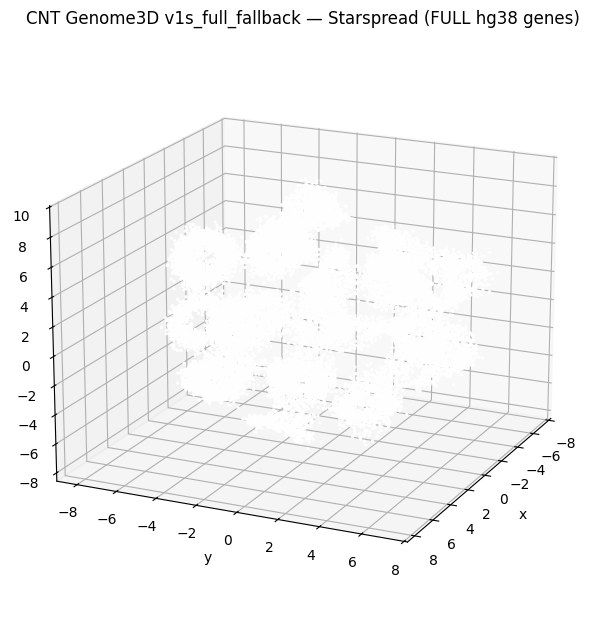

In [14]:
# === GTF REINDEX + FULL GENES + FULL ATLAS (one cell) =========================
# 1) Scan CNT_LAB_DIR for *.gtf / *.gtf.gz; route to data/raw/annotations/gtf and tag
# 2) Parse the best GTF → build genome3d__atlas__genes_v1_full.parquet (all gene types, no caps)
# 3) If coverage has all chr1–22,X,Y,MT → build a complete v1s_full atlas

import os, re, gzip, json
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import cntlab as cl

cl.nb.init(); P = cl.P

# ---------------- 0) Route any GTFs and tag ----------------
gtf_home = P.root / "data" / "raw" / "annotations" / "gtf"
gtf_home.mkdir(parents=True, exist_ok=True)

found = []
for root, dirs, files in os.walk(P.root):
    if any(skip in root for skip in [".venv","__pycache__","artifacts\\figures","artifacts\\models","artifacts\\tables","artifacts\\metrics"]):
        continue
    for fn in files:
        fnl = fn.lower()
        if fnl.endswith(".gtf") or fnl.endswith(".gtf.gz"):
            found.append(Path(root)/fn)

routed = 0
for src in found:
    dst = gtf_home / src.name
    if not dst.exists():
        try: src.replace(dst)
        except Exception:
            import shutil; shutil.copy2(src, dst)
        tags = ["raw","annotations","gtf"]
        if any(k in src.name.lower() for k in ["hg38","grch38"]): tags.append("hg38")
        cl.manifest.log_artifact(dst, kind="blob", tags=tags, meta={"relocated_from": str(src)})
        routed += 1
if routed: print(f"[GTF ROUTE] Moved/tagged {routed} file(s) → {gtf_home}")

# ---------------- 1) Pick a GTF to parse (prefer hg38/grch38) ---------------
gtf_hits = cl.manifest.find_artifacts(kind="blob", tags_all=["raw","annotations","gtf"])
assert gtf_hits, "No GTF found anywhere under your lab. Please add a full hg38 GTF and re-run."
def score_gtf(path):
    nm = Path(path).name.lower()
    score = 0
    if "hg38" in nm or "grch38" in nm: score += 10
    if "gencode" in nm: score += 5
    return score

best = sorted(gtf_hits, key=lambda h: (score_gtf(h["path"]), h["path"]))[-1]["path"]
print("[GTF] Using:", best)

# ---------------- 2) Parse ALL genes (robust) → genes_v1_full ----------------
is_gz = str(best).lower().endswith(".gz")
opn = gzip.open if is_gz else open

def norm_chr(seq):
    s = str(seq).strip().replace("CHR","chr").replace("Chr","chr")
    if not s.lower().startswith("chr"): s = "chr"+s
    if s=="chrM": s="chrMT"
    return s

rows = []
types_counter = {}
with opn(best, "rt", encoding="utf-8", errors="ignore") as fh:
    for line in fh:
        if not line or line.startswith("#"): continue
        parts = line.rstrip("\n").split("\t")
        if len(parts) < 9: continue
        seq, feat, start, end, attrs = parts[0], parts[2], parts[3], parts[4], parts[8]
        if feat != "gene": continue
        ch = norm_chr(seq)
        mname = re.search(r'gene_name\s+"([^"]+)"', attrs) or re.search(r'gene_id\s+"([^"]+)"', attrs)
        gname = mname.group(1) if mname else ""
        mtype = re.search(r'(gene_type|gene_biotype)\s+"([^"]+)"', attrs)
        gtype = mtype.group(2) if mtype else ""
        try:
            s = int(start); e = int(end)
        except: 
            continue
        pos = (s+e)//2
        rows.append((ch, pos, gname, gtype))
        types_counter[gtype] = types_counter.get(gtype,0)+1

genes_full = pd.DataFrame(rows, columns=["chr","pos","gene","type"])
assert len(genes_full), "Parsed 0 genes from chosen GTF (unexpected)."

# Normalize chr labels and report coverage
genes_full["chr"] = (genes_full["chr"].astype(str)
                     .str.replace("^CHR","chr", regex=True)
                     .str.replace("^chrM$", "chrMT", regex=True))
expected = [f"chr{i}" for i in range(1,23)] + ["chrX","chrY","chrMT"]
by_chr = genes_full.groupby("chr").size().sort_index()
missing = [c for c in expected if c not in by_chr.index]
print("GTF counts by chr:", by_chr.to_dict())
print("Missing in GTF:", "None" if not missing else ", ".join(missing))

# Save the full genes table (v1_full)
genes_v1_full_path = cl.io.save_df(genes_full, module="genome3d", dataset="atlas",
                                   desc="genes_v1_full", fmt="parquet",
                                   tags=["genome3d","atlas","v1","genes","full"])
print("Saved genes_v1_full →", genes_v1_full_path)

# If still missing chromosomes in the GTF, we can stop here (no real gene data to plot).
if missing:
    print("\n== STOPPING: Your GTF is missing those chromosomes. ==")
    print("Add a complete hg38 GTF (e.g., GENCODE hg38) into data/raw/annotations/gtf/,")
    print("then re-run this cell to build the full 24-chromosome atlas.")
else:
    # ---------------- 3) Build full-sky backbones & star-spread for ALL chrs --------------
    # Use gene maxima for lengths (good enough for mapping); FASTA (if present) will tighten later
    chr_len = genes_full.groupby("chr")["pos"].max().to_dict()

    # layout
    def fibonacci_sphere(n):
        k = np.arange(n); phi = (1+5**0.5)/2
        z = 1 - 2*(k+0.5)/n
        r = np.sqrt(np.maximum(0,1 - z*z))
        th= 2*np.pi*k/phi
        return np.vstack([r*np.cos(th), r*np.sin(th), z]).T

    def relax(points, steps, step_size, min_dist):
        P = points.astype(float).copy()
        for _ in range(steps):
            disp = np.zeros_like(P)
            for i in range(len(P)):
                d = P[i] - P
                dist = np.linalg.norm(d, axis=1) + 1e-9
                mask = (dist < min_dist) & (dist > 1e-6)
                if np.any(mask):
                    rep = (d[mask]/dist[mask][:,None]) * (min_dist - dist[mask])[:,None]
                    disp[i] += rep.sum(axis=0)
            P += step_size*disp
        return P

    def chr_key(ch):
        tail = ch[3:]
        return (0, int(tail)) if tail.isdigit() else (1, {"X":23,"Y":24,"MT":25}.get(tail.upper(), 99))

    chrs = sorted(expected, key=chr_key)
    N = len(chrs)
    centers = relax(fibonacci_sphere(N)*SPHERE_R, REP_STEPS, REP_STEP_SIZE, REP_MIN_DIST)
    tangents = np.roll(centers, 7, axis=0)

    lens = np.array([chr_len[ch] for ch in chrs], dtype=float)
    lens_norm = (lens - lens.min()) / (lens.max() - lens.min() + 1e-9)
    arc_r = ARC_BASE + ARC_RANGE * lens_norm

    def make_backbone(center, tangent, radius, n_knots=110):
        t = tangent / (np.linalg.norm(tangent)+1e-12)
        ref = np.array([0.123,0.456,0.789])
        n = np.cross(t, ref)
        if np.linalg.norm(n) < 1e-6: n = np.cross(t, np.array([0,1,0]))
        n = n/(np.linalg.norm(n)+1e-12)
        b = np.cross(t, n)
        ang = np.linspace(-np.pi/5, np.pi/5, n_knots)
        return np.array([center + radius*(np.cos(a)*n + np.sin(a)*b) for a in ang])

    backbones = {ch: make_backbone(centers[i], tangents[i], arc_r[i]) for i,ch in enumerate(chrs)}

    def sample_polyline(P, s):
        s = np.clip(s, 0, 1)
        x = s*(len(P)-1)
        i0 = np.floor(x).astype(int)
        i1 = np.clip(i0+1, 0, len(P)-1)
        t  = (x - i0).reshape(-1,1)
        return (1-t)*P[i0] + t*P[i1]

    def tangent_polyline(P, s):
        eps=1e-3
        a = sample_polyline(P, np.clip(s-eps,0,1))
        b = sample_polyline(P, np.clip(s+eps,0,1))
        v = b - a
        nrm = np.linalg.norm(v, axis=1, keepdims=True)+1e-12
        return v/nrm

    def frame_TNB(P, s):
        T = tangent_polyline(P, s)
        ref = np.tile(np.array([[0.12,0.97,0.21]]),(len(T),1))
        dot = np.abs((T*ref).sum(axis=1))
        if (dot>0.95).any(): ref[dot>0.95] = np.array([0.35,0.05,0.93])
        N = np.cross(T, ref); N/= (np.linalg.norm(N,axis=1,keepdims=True)+1e-12)
        B = np.cross(T, N);    B/= (np.linalg.norm(B,axis=1,keepdims=True)+1e-12)
        return T,N,B

    # star-spread all genes
    rows=[]
    for ch, g in genes_full.groupby("chr", sort=False):
        if ch not in backbones: 
            continue
        P = backbones[ch]
        Lbp = max(1, int(chr_len.get(ch, g["pos"].max())))
        s = np.clip((g["pos"].to_numpy()/Lbp).reshape(-1,1), 0, 1).flatten()
        base = sample_polyline(P, s)
        T,N,B = frame_TNB(P, s)
        aN, aB = ANISO
        ang    = np.random.default_rng(SEED).uniform(0, 2*np.pi, size=len(s))
        jitter = 1.0 + R_JITTER_FRAC*np.random.default_rng(SEED).normal(0, 0.6, size=len(s))
        r      = np.maximum(0.0, R_PERP * jitter)
        dN = r * aN * np.cos(ang)
        dB = r * aB * np.sin(ang)
        offs = N*dN.reshape(-1,1) + B*dB.reshape(-1,1)
        pos3 = base + offs
        part = pd.DataFrame({
            "id":   g.apply(lambda r: f"{(r['gene'] or 'id')}|{ch}|{int(r['pos'])}", axis=1).values,
            "chr":  ch, "kind":"gene", "pos": g["pos"].astype(int).values,
            "x": pos3[:,0], "y": pos3[:,1], "z": pos3[:,2],
            "gene": g.get("gene","").values, "type": g.get("type","").values
        })
        rows.append(part)

    nodes_full = pd.concat(rows, ignore_index=True)

    # save nodes + summary
    nodes_path = cl.io.save_df(nodes_full, module="genome3d", dataset="atlas",
                               desc="nodes_v1s_full_fallback", fmt="parquet",
                               tags=["genome3d","atlas","v1s_full_fallback"])
    by_chr2 = nodes_full.groupby("chr").size().sort_index()
    summary2 = {
        "n_genes": int(len(nodes_full)),
        "by_chr": {k:int(v) for k,v in by_chr2.items()},
        "missing": [c for c in expected if c not in by_chr2.index],
        "length_source": "GTF max bp (fallback). Add FASTA to tighten absolute scaling.",
        "layout": {"SPHERE_R": SPHERE_R, "repulsion": {"steps": REP_STEPS, "step": REP_STEP_SIZE, "min_dist": REP_MIN_DIST}},
        "spread": {"R_PERP": R_PERP, "R_JITTER_FRAC": R_JITTER_FRAC, "ANISO": ANISO}
    }
    met2 = cl.io.save_json(summary2, module="genome3d", dataset="atlas",
                           desc="summary_v1s_full_fallback", tags=["genome3d","atlas","v1s_full_fallback"])
    print("Saved full atlas summary →", met2)
    print("Counts by chr:", by_chr2.to_dict())
    print("Missing:", summary2["missing"] if summary2["missing"] else "None")

    # static + HTML
    fig = plt.figure(figsize=(9.6,7.6))
    ax = fig.add_subplot(111, projection='3d')
    sample = nodes_full.sample(min(22_000, len(nodes_full)), random_state=SEED)
    ax.scatter(sample["x"], sample["y"], sample["z"], s=2, c="white", alpha=0.9)
    ax.set_title("CNT Genome3D v1s_full_fallback — Starspread (FULL hg38 genes)")
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    ax.view_init(elev=18, azim=25)
    figp = cl.io.save_figure(fig, module="genome3d", dataset="atlas",
                             desc="figure_v1s_full_fallback", tags=["genome3d","atlas","v1s_full_fallback"])
    print("Figure →", figp)
    try:
        import plotly.graph_objects as go
    except ModuleNotFoundError:
        import sys, subprocess; subprocess.check_call([sys.executable,"-m","pip","install","plotly>=5.24"])
        import plotly.graph_objects as go
    stars = nodes_full if len(nodes_full)<=MAX_HTML_PTS else nodes_full.sample(MAX_HTML_PTS, random_state=SEED)
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=stars["x"], y=stars["y"], z=stars["z"], mode="markers",
                               marker=dict(size=1.8, color="rgba(255,255,255,0.97)"),
                               name="genes",
                               customdata=np.stack([stars.get("gene",""), stars["chr"], stars["pos"], stars.get("type","")], axis=1),
                               hovertemplate="gene: %{customdata[0]}<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>type: %{customdata[3]}"))
    bg = "#05070b"; axis = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False,
                                color="rgba(255,255,255,0.25)")
    fig.update_layout(title="<b>Genome3D v1s_full_fallback — Starspread (FULL hg38)</b>",
                      scene=dict(bgcolor=bg, xaxis=axis, yaxis=axis, zaxis=axis, aspectmode="data"),
                      paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.88)"),
                      height=880, width=1240, margin=dict(l=0,r=0,t=60,b=0))
    html = fig.to_html(include_plotlyjs="cdn", full_html=True)
    htmlp = cl.io.save_bytes(html.encode("utf-8"), module="genome3d", dataset="atlas",
                             desc="interactive_v1s_full_fallback", tags=["genome3d","atlas","v1s_full_fallback","interactive"], ext="html")
    print("Interactive →", htmlp)


In [15]:
# === Genome3D • Threaded + Drift (single cell) ================================
# Threads genes along each chromosome and renders an animated “drift” starfield.
# Outputs:
#   tables: genome3d__atlas__thread_edges_v1s_full.parquet
#   html  : genome3d__atlas__interactive_v1s_full_threaded_drift.html
# Tags: ["genome3d","atlas","v1s_full","threaded","drift","interactive"]

import numpy as np, pandas as pd
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P

# ------------------ Tuning ------------------
MAX_POINTS   = 120_000      # cap for live points (HTML remains smooth)
DRIFT_AMP    = 0.28         # drift amplitude (scene units)
DRIFT_SPEED  = 1.0          # 1.0 → one full sine cycle over N_FRAMES
N_FRAMES     = 60           # animation frames
SEED         = 1337         # deterministic

# ------------------ Load nodes (prefer v1s_full_fallback/full; fallback to v1s_plus/v1h) ------------------
def grab_nodes_order():
    for tags in [["v1s_full_fallback"], ["v1s_full"], ["v1s_plus"], ["v1h"]]:
        hits = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas"] + tags)
        if hits:
            # prefer nodes parquet
            for h in reversed(hits):
                nm = Path(h["path"]).name.lower()
                if "nodes" in nm and nm.endswith(".parquet"):
                    df = pd.read_parquet(h["path"])
                    return df, "_".join(tags)
            # otherwise take the most recent
            df = pd.read_parquet(hits[-1]["path"])
            return df, "_".join(tags)
    raise AssertionError("No atlas nodes found (v1s_full_fallback / v1s_full / v1s_plus / v1h).")

nodes_raw, N_TAG = grab_nodes_order()
nodes = nodes_raw.copy()

# normalize minimal schema
if "kind" not in nodes: nodes["kind"] = "gene"
nodes["kind"] = nodes["kind"].astype(str).str.lower()
nodes = nodes[nodes["kind"]=="gene"].copy()
for c in ["gene","type"]:
    if c not in nodes: nodes[c] = ""

# required columns
for c in ["chr","pos","x","y","z"]:
    if c not in nodes.columns:
        raise AssertionError(f"Missing column '{c}' in nodes table (tag={N_TAG}).")

# sanitize dtypes
nodes["pos"] = pd.to_numeric(nodes["pos"], errors="coerce").fillna(0).astype(int)
for c in ["x","y","z"]:
    nodes[c] = pd.to_numeric(nodes[c], errors="coerce")
nodes = nodes.dropna(subset=["x","y","z"]).copy()

# ------------------ THREADS: build faint per-chr polylines ------------------
# For each chromosome, connect genes in genomic order with line segments
edge_rows = []
for ch, g in nodes.groupby("chr", sort=False):
    g = g.sort_values("pos")
    X = g[["x","y","z"]].to_numpy()
    if len(X) < 2: 
        continue
    for i in range(len(X)-1):
        x0,y0,z0 = X[i]
        x1,y1,z1 = X[i+1]
        edge_rows.append((f"{ch}:{i}", ch, i, x0,y0,z0, x1,y1,z1))
edges_df = pd.DataFrame(edge_rows, columns=["id","chr","seg","x0","y0","z0","x1","y1","z1"])

edges_path = cl.io.save_df(edges_df, module="genome3d", dataset="atlas",
                           desc="thread_edges_v1s_full", fmt="parquet",
                           tags=["genome3d","atlas","v1s_full","threads"])
print("Saved threads →", edges_path)

# ------------------ DRIFT: procedural animation for points ------------------
# Each gene gets a deterministic unit direction and a phase from genomic rank.
from pandas.util import hash_pandas_object
sig = nodes[["chr","pos"]].astype(str).agg("|".join, axis=1)
hval = hash_pandas_object(sig, index=False).astype("uint64").to_numpy()

rng = np.random.default_rng(SEED)
# Deterministic directions from hash (not random at runtime)
def hash_to_unit(u64):
    # map 64-bit to 3 angles and form a unit vector
    a = (u64 % (2**16)) / (2**16)        # 0..1
    b = ((u64 // (2**16)) % (2**16)) / (2**16)
    theta = 2*np.pi*a
    z = 2*b - 1
    r = np.sqrt(np.maximum(0,1 - z*z))
    return np.column_stack([r*np.cos(theta), r*np.sin(theta), z])

dir_vec = hash_to_unit(hval)            # (N,3) unit vectors

# phase along chromosome based on genomic rank (0..1)
rank = nodes.groupby("chr")["pos"].rank(method="first") - 1
den  = nodes.groupby("chr")["pos"].transform("count").clip(lower=1)
phase = (rank / den).to_numpy()         # (N,)

base_xyz = nodes[["x","y","z"]].to_numpy()
N = len(nodes)

# Points to show in the animation
if N > MAX_POINTS:
    sel_idx = nodes.sample(MAX_POINTS, random_state=SEED).index.to_numpy()
else:
    sel_idx = nodes.index.to_numpy()

XYZ0 = base_xyz[sel_idx]
DIR  = dir_vec[sel_idx]
PHI  = phase[sel_idx]
GENE = nodes.loc[sel_idx, "gene"].astype(str).to_numpy()
CHR  = nodes.loc[sel_idx, "chr"].astype(str).to_numpy()
POS  = nodes.loc[sel_idx, "pos"].astype(int).to_numpy()
TYP  = nodes.loc[sel_idx, "type"].astype(str).to_numpy()

# Precompute line coords (threads) as NaN-separated polylines per chr
lines_x, lines_y, lines_z = [], [], []
for ch, segs in edges_df.groupby("chr", sort=False):
    x = np.column_stack([segs["x0"].to_numpy(), segs["x1"].to_numpy()]).ravel(order="C")
    y = np.column_stack([segs["y0"].to_numpy(), segs["y1"].to_numpy()]).ravel(order="C")
    z = np.column_stack([segs["z0"].to_numpy(), segs["z1"].to_numpy()]).ravel(order="C")
    # insert NaNs to break segments
    x = np.insert(x, np.arange(2, x.size, 2), np.nan)
    y = np.insert(y, np.arange(2, y.size, 2), np.nan)
    z = np.insert(z, np.arange(2, z.size, 2), np.nan)
    lines_x.append(x); lines_y.append(y); lines_z.append(z)

# ------------------ Build Plotly animation ------------------
try:
    import plotly.graph_objects as go
except ModuleNotFoundError:
    import sys, subprocess; subprocess.check_call([sys.executable, "-m", "pip", "install", "plotly>=5.24"])
    import plotly.graph_objects as go

# Initial positions (t=0)
t0 = 0.0
disp0 = DRIFT_AMP * np.sin(2*np.pi*(DRIFT_SPEED*t0 + PHI))[:,None] * DIR
XYZ = XYZ0 + disp0

fig = go.Figure()

# Thread lines (static, faint)
for x,y,z in zip(lines_x, lines_y, lines_z):
    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z, mode="lines",
        line=dict(width=1.2, color="rgba(255,255,255,0.15)"),
        hoverinfo="skip", showlegend=False
    ))

# Points (animated)
fig.add_trace(go.Scatter3d(
    x=XYZ[:,0], y=XYZ[:,1], z=XYZ[:,2], mode="markers",
    marker=dict(size=2.0, color="rgba(255,255,255,0.95)"),
    name="genes",
    customdata=np.stack([GENE, CHR, POS, TYP, PHI], axis=1),
    hovertemplate=("gene: %{customdata[0]}<br>"
                   "chr: %{customdata[1]}  pos: %{customdata[2]}<br>"
                   "type: %{customdata[3]}")
))

# Frames
frames = []
for f in range(1, N_FRAMES+1):
    tf = f / N_FRAMES
    disp = DRIFT_AMP * np.sin(2*np.pi*(DRIFT_SPEED*tf + PHI))[:,None] * DIR
    XYZf = XYZ0 + disp
    # optional shimmer: modulate size by phase alignment
    size = 1.8 + 0.6*np.maximum(0, np.cos(2*np.pi*(DRIFT_SPEED*tf + PHI)))
    frames.append(go.Frame(data=[  # only the last trace (points) changes
        go.Scatter3d(
            x=XYZf[:,0], y=XYZf[:,1], z=XYZf[:,2],
            mode="markers",
            marker=dict(size=size, color="rgba(255,255,255,0.96)")
        )
    ]))

fig.frames = frames

# Layout + animation controls
bg = "#06080d"
axis = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False,
            color="rgba(255,255,255,0.25)")
fig.update_layout(
    title=f"Genome3D — Threaded & Drift (source: {N_TAG})",
    scene=dict(bgcolor=bg, xaxis=axis, yaxis=axis, zaxis=axis, aspectmode="data"),
    paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.90)"),
    height=880, width=1240, margin=dict(l=0,r=0,t=60,b=0),
    updatemenus=[dict(
        type="buttons", direction="left", x=0.02, y=1.10, pad={"r":6,"t":6},
        buttons=[
            dict(label="► Play", method="animate",
                 args=[None, {"frame": {"duration": 50, "redraw": False},
                              "fromcurrent": True, "transition": {"duration": 0}}]),
            dict(label="❚❚ Pause", method="animate",
                 args=[[None], {"frame": {"duration": 0}, "mode":"immediate"}]),
            dict(label="Reset", method="animate",
                 args=[[fig.frames[0].name] if fig.frames else [None],
                       {"frame":{"duration":0},"mode":"immediate"}])
        ]
    )]
)

# Save HTML
html = fig.to_html(include_plotlyjs="cdn", full_html=True)
html_path = cl.io.save_bytes(html.encode("utf-8"),
                             module="genome3d", dataset="atlas",
                             desc="interactive_v1s_full_threaded_drift",
                             tags=["genome3d","atlas","v1s_full","threaded","drift","interactive"],
                             ext="html")
print("Interactive (threaded+drift) →", html_path)


[2025-10-08 23:27:19,398] INFO cntlab: CNTLab notebook initialized
[2025-10-08 23:27:19,399] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Saved threads → C:\Users\caleb\CNT_Lab\artifacts\tables\genome3d__atlas__thread_edges_v1s_full__20251008-232719.parquet
Interactive (threaded+drift) → C:\Users\caleb\CNT_Lab\artifacts\genome3d__atlas__interactive_v1s_full_threaded_drift__20251008-232722.html


In [16]:
# === Genome3D • Color each chromosome cloud (single cell) =====================
# Outputs:
#   figure: genome3d__atlas__figure_v1s_full_fallback_colored.png
#   html  : genome3d__atlas__interactive_v1s_full_fallback_colored.html
# Tags: ["genome3d","atlas","v1s_full_fallback","colored", ("interactive" for HTML)]

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P

# ---------- load full starspread nodes ----------
def load_nodes():
    # preference: v1s_full_fallback → v1s_full → v1s_plus → v1h
    for tag in ["v1s_full_fallback","v1s_full","v1s_plus","v1h"]:
        H = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas",tag])
        if not H: 
            continue
        # prefer nodes parquet
        for h in reversed(H):
            nm = Path(h["path"]).name.lower()
            if nm.endswith(".parquet") and "nodes" in nm:
                df = pd.read_parquet(h["path"]).copy()
                df["__tag__"] = tag
                return df, tag
        df = pd.read_parquet(H[-1]["path"]).copy()
        df["__tag__"] = tag
        return df, tag
    raise AssertionError("No atlas nodes found.")

nodes, TAG = load_nodes()
if "kind" in nodes.columns:
    nodes = nodes[nodes["kind"].astype(str).str.lower()=="gene"].copy()

# minimal checks
for c in ["chr","x","y","z"]:
    assert c in nodes.columns, f"Missing column '{c}'"

# ---------- stable chromosome order & palette ----------
def chr_key(ch):
    ch = str(ch)
    t = ch[3:] if ch.startswith("chr") else ch
    return (0, int(t)) if t.isdigit() else (1, {"X":23,"Y":24,"MT":25}.get(t.upper(), 99))

chrs = sorted(nodes["chr"].astype(str).unique(), key=chr_key)

palette = [
    "#4c78a8","#f58518","#54a24b","#e45756","#72b7b2","#b279a2",
    "#ff9da6","#9d755d","#bab0ab","#ff7f0e","#2ca02c","#d62728",
    "#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",
    "#1f77b4","#aec7e8","#ffbb78","#98df8a","#ff9896","#c5b0d5"
]
color_by_chr = {ch: palette[i % len(palette)] for i,ch in enumerate(chrs)}

# ---------- STATIC: colored scatter ----------
fig = plt.figure(figsize=(9.6,7.6))
ax = fig.add_subplot(111, projection='3d')
# light subsample to keep the static image crisp
S = nodes if len(nodes)<=24000 else nodes.sample(24000, random_state=1337)
for ch, g in S.groupby("chr", sort=False):
    ax.scatter(g["x"], g["y"], g["z"], s=3, alpha=0.9, c=color_by_chr.get(ch,"#ccc"), label=ch)
ax.set_title(f"CNT Genome3D ({TAG}) — Chromosome-colored starspread")
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
ax.view_init(elev=18, azim=25)
# small legend outside plot
ax.legend(loc="upper left", bbox_to_anchor=(1.04, 1.0), fontsize=7, ncol=1, frameon=False)
png_path = cl.io.save_figure(fig, module="genome3d", dataset="atlas",
                             desc=f"figure_{TAG}_colored", tags=["genome3d","atlas",TAG,"colored"])
plt.close(fig)
print("Static figure →", png_path)

# ---------- INTERACTIVE: per-chr colored layers ----------
try:
    import plotly.graph_objects as go
except ModuleNotFoundError:
    import sys, subprocess; subprocess.check_call([sys.executable,"-m","pip","install","plotly>=5.24"])
    import plotly.graph_objects as go

fig = go.Figure()
MAX_HTML_PTS = 140_000
base = nodes if len(nodes)<=MAX_HTML_PTS else nodes.sample(MAX_HTML_PTS, random_state=1337)

for ch, g in base.groupby("chr", sort=False):
    fig.add_trace(go.Scatter3d(
        x=g["x"], y=g["y"], z=g["z"],
        mode="markers",
        marker=dict(size=1.9, color=color_by_chr.get(ch,"#ccc")),
        name=ch,
        customdata=np.stack([g.get("gene",""), g["chr"], g.get("pos",0), g.get("type","")], axis=1),
        hovertemplate="chr: %{customdata[1]}  pos: %{customdata[2]}<br>gene: %{customdata[0]}<br>type: %{customdata[3]}"
    ))

bg = "#05070b"
axis = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False,
            color="rgba(255,255,255,0.25)")
fig.update_layout(
    title=f"Genome3D ({TAG}) — Chromosome-colored starspread",
    scene=dict(bgcolor=bg, xaxis=axis, yaxis=axis, zaxis=axis, aspectmode="data"),
    paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.88)"),
    height=880, width=1240, margin=dict(l=0,r=0,t=60,b=0),
    legend=dict(itemsizing="constant", bgcolor="rgba(0,0,0,0)")
)

html = fig.to_html(include_plotlyjs="cdn", full_html=True)
html_path = cl.io.save_bytes(html.encode("utf-8"),
                             module="genome3d", dataset="atlas",
                             desc=f"interactive_{TAG}_colored",
                             tags=["genome3d","atlas",TAG,"interactive","colored"], ext="html")
print("Interactive (colored) →", html_path)


[2025-10-08 23:31:15,395] INFO cntlab: CNTLab notebook initialized
[2025-10-08 23:31:15,396] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Static figure → C:\Users\caleb\CNT_Lab\artifacts\figures\genome3d__atlas__figure_v1s_full_fallback_colored__20251008-233115.png
Interactive (colored) → C:\Users\caleb\CNT_Lab\artifacts\genome3d__atlas__interactive_v1s_full_fallback_colored__20251008-233116.html


In [17]:
# === Genome3D (v1s_full_fallback) • Interactive color viewer ==================
# - Default: color by chromosome
# - Toggle: color by gene type (protein_coding, lncRNA, miRNA, …, other)
# - Focus dropdown: show a single chromosome or all
# Saves: HTML tagged in the manifest.

import numpy as np, pandas as pd
from pathlib import Path
import cntlab as cl

cl.nb.init(); P = cl.P

# ---------- Load full atlas nodes ----------
def load_nodes():
    for tag in ["v1s_full_fallback","v1s_full"]:
        H = cl.manifest.find_artifacts(kind="table", tags_all=["genome3d","atlas",tag])
        if H:
            # prefer nodes parquet
            for h in reversed(H):
                nm = Path(h["path"]).name.lower()
                if "nodes" in nm and nm.endswith(".parquet"):
                    df = pd.read_parquet(h["path"]).copy()
                    df["__tag__"] = tag
                    return df, tag
            df = pd.read_parquet(H[-1]["path"]).copy()
            df["__tag__"] = tag
            return df, tag
    raise AssertionError("No full atlas nodes (v1s_full_fallback / v1s_full) found.")

nodes, TAG = load_nodes()
if "kind" in nodes.columns:
    nodes = nodes[nodes["kind"].astype(str).str.lower()=="gene"].copy()

# minimal schema
for c in ["gene","type"]:
    if c not in nodes: nodes[c] = ""
for c in ["chr","x","y","z","pos"]:
    assert c in nodes.columns, f"Missing column '{c}'"

# Nice chr order
def chr_key(ch):
    ch = str(ch)
    t = ch[3:] if ch.startswith("chr") else ch
    return (0, int(t)) if t.isdigit() else (1, {"X":23,"Y":24,"MT":25}.get(t.upper(), 99))
chrs = sorted(nodes["chr"].astype(str).unique(), key=chr_key)

# Downsample for HTML performance (table on disk already has everything)
MAX_HTML_PTS = 160_000
base = nodes if len(nodes)<=MAX_HTML_PTS else nodes.sample(MAX_HTML_PTS, random_state=1337)

# Palettes
chr_palette = [
    "#4c78a8","#f58518","#54a24b","#e45756","#72b7b2","#b279a2",
    "#ff9da6","#9d755d","#bab0ab","#ff7f0e","#2ca02c","#d62728",
    "#9467bd","#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",
    "#1f77b4","#aec7e8","#ffbb78","#98df8a","#ff9896","#c5b0d5"
]
color_by_chr = {ch: chr_palette[i % len(chr_palette)] for i,ch in enumerate(chrs)}

type_counts = base["type"].fillna("").replace("", "other").value_counts()
top_types = list(type_counts.index[:8])
base["type_slim"] = base["type"].fillna("").replace("", "other")
base.loc[~base["type_slim"].isin(top_types), "type_slim"] = "other"
types = sorted(base["type_slim"].unique(), key=lambda t: (0, -type_counts.get(t,0)) if t!="other" else (1,0))
type_palette = [
    "#00876c","#6aaa96","#d3d3d3","#d4886a","#c43e3f","#5b5bff","#c06cdb","#ffa600"
]
color_by_type = {t: type_palette[i % len(type_palette)] for i,t in enumerate(types)}

# ---------- Build Plotly scene ----------
try:
    import plotly.graph_objects as go
except ModuleNotFoundError:
    import sys, subprocess; subprocess.check_call([sys.executable,"-m","pip","install","plotly>=5.24"])
    import plotly.graph_objects as go

fig = go.Figure()

# Backbones-as-clouds: chromosome traces (active)
for ch, g in base.groupby("chr", sort=False):
    fig.add_trace(go.Scatter3d(
        x=g["x"], y=g["y"], z=g["z"], mode="markers",
        marker=dict(size=1.8, color=color_by_chr.get(ch,"#ccc")),
        name=f"{ch} genes",
        customdata=np.stack([g.get("gene",""), g["chr"], g["pos"], g.get("type","")], axis=1),
        hovertemplate="chr: %{customdata[1]}  pos: %{customdata[2]}<br>gene: %{customdata[0]}<br>type: %{customdata[3]}",
        visible=True
    ))
n_chr_traces = len(fig.data)

# Type-colored traces (start hidden)
for t, g in base.groupby("type_slim", sort=False):
    fig.add_trace(go.Scatter3d(
        x=g["x"], y=g["y"], z=g["z"], mode="markers",
        marker=dict(size=1.8, color=color_by_type.get(t,"#888")),
        name=f"{t} genes",
        customdata=np.stack([g.get("gene",""), g["chr"], g["pos"], g.get("type","")], axis=1),
        hovertemplate="type: "+t+"<br>chr: %{customdata[1]}  pos: %{customdata[2]}<br>gene: %{customdata[0]}",
        visible=False
    ))
n_type_traces = len(fig.data) - n_chr_traces

def vis_all(mode="chr"):
    if mode=="chr":
        return [True]*n_chr_traces + [False]*n_type_traces
    else:
        return [False]*n_chr_traces + [True]*n_type_traces

def vis_only_chr(target):
    # show only target chromosome (in chr-mode)
    vis = []
    for tr in fig.data[:n_chr_traces]:
        vis.append(tr.name.startswith(target))
    vis += [False]*n_type_traces
    return vis

# Buttons
buttons_mode = [
    dict(label="Color by chromosome", method="update",
         args=[{"visible": vis_all("chr")}, {"title": f"Genome3D ({TAG}) — chromosome mode"}]),
    dict(label="Color by gene type", method="update",
         args=[{"visible": vis_all("type")}, {"title": f"Genome3D ({TAG}) — gene-type mode"}])
]
dropdown_focus = [dict(label="All chromosomes", method="update",
                       args=[{"visible": vis_all("chr")}, {}])]
for ch in chrs:
    dropdown_focus.append(dict(label=f"Focus: {ch}", method="update",
                               args=[{"visible": vis_only_chr(ch)}, {}]))

# Layout
bg = "#05070b"
axis = dict(showgrid=False, showline=False, zeroline=False, ticks="", showbackground=False,
            color="rgba(255,255,255,0.25)")
fig.update_layout(
    title=f"Genome3D ({TAG}) — Chromosome-colored starspread",
    scene=dict(bgcolor=bg, xaxis=axis, yaxis=axis, zaxis=axis, aspectmode="data"),
    paper_bgcolor=bg, font=dict(color="rgba(255,255,255,0.88)"),
    height=880, width=1240, margin=dict(l=0,r=0,t=60,b=0),
    legend=dict(itemsizing="constant", bgcolor="rgba(0,0,0,0)"),
    updatemenus=[
        dict(type="buttons", direction="left", x=0.01, y=1.08, buttons=buttons_mode, pad={"r":6,"t":6}),
        dict(type="dropdown", direction="down", x=0.63, y=1.08, buttons=dropdown_focus, pad={"r":6,"t":6})
    ]
)

# Save HTML
html = fig.to_html(include_plotlyjs="cdn", full_html=True)
html_path = cl.io.save_bytes(html.encode("utf-8"),
                             module="genome3d", dataset="atlas",
                             desc=f"interactive_{TAG}_colored",
                             tags=["genome3d","atlas",TAG,"interactive","colored"], ext="html")
print("Interactive (colored) →", html_path)


[2025-10-08 23:35:14,323] INFO cntlab: CNTLab notebook initialized
[2025-10-08 23:35:14,324] INFO cntlab: CNT Paths(root=C:\Users\caleb\CNT_Lab)


→ CNTLab ready.
   Root: C:\Users\caleb\CNT_Lab
   Figures: C:\Users\caleb\CNT_Lab\artifacts\figures
   Tables: C:\Users\caleb\CNT_Lab\artifacts\tables
   Metrics: C:\Users\caleb\CNT_Lab\artifacts\metrics
Interactive (colored) → C:\Users\caleb\CNT_Lab\artifacts\genome3d__atlas__interactive_v1s_full_fallback_colored__20251008-233514.html
